# **Lab 5: Wide & Deep Neural Networks**

- Eileen Garcia: 48241821
- Reece Iriye: 48255107
- Trevor Dohm: 48376059

## **0: Imports**

In [37]:
# Some standard Data Science libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
 
# Scikit-learn Imports
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics as mt

# Tensorflow Imports
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, FeatureSpace
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers.legacy import Adam

# Standard library imports
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings("ignore")

## **1: Preparation**

Let's begin by loading the dataset.

In [2]:
df_original_csv: pd.DataFrame = pd.read_csv("Dataset/corona.csv")
df_original_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ind_ID               278848 non-null  int64 
 1   Test_date            278848 non-null  object
 2   Cough_symptoms       278596 non-null  object
 3   Fever                278596 non-null  object
 4   Sore_throat          278847 non-null  object
 5   Shortness_of_breath  278847 non-null  object
 6   Headache             278847 non-null  object
 7   Corona               278848 non-null  object
 8   Age_60_above         151528 non-null  object
 9   Sex                  259285 non-null  object
 10  Known_contact        278848 non-null  object
dtypes: int64(1), object(10)
memory usage: 23.4+ MB


After printing out some basic information about the dataset, we can note a few things:
- The dataset includes mostly categorical features and we will need to one-hot encode these features.
- "Ind_ID" and "Test_date" will likely be irrelevant, or at least shouldn't be used for prediction purposes when deployed since we want to predict if a patient has COVID-19 based on symptoms, not time.
- We want to remove instances missing values from the columns "Cough_symptoms", "Fever", "Sore_throat", "Shortness_of_breath", and "Headache" since there are so few instances missing that data.
- We may want to consider removing instances with missing values in the "Sex" columns. It would remove only about 19,563 instances. 
- The "Age_60_above" column has about 127,000 missing values. That is too many instances to remove without risking overfitting from lack of data. We may need to impute them, or remove the column entirely, or use "None" as its own category within the feature if the age turns out to be a strong predictor of whether the patient has contracted COVID-19.

In [3]:
# Dataset Size
row_count, col_count = df_original_csv.shape
print(f"The dataset contains {row_count} rows and {col_count} columns.")

The dataset contains 278848 rows and 11 columns.


The original dataset contains nearly 279,000 instances and 11 features, including the target variable: "Corona".

### **1.1: Define and Prepare Class Variables**


```
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required.
```

As part of our data preparation process, one crucial step is identifying and understanding the distribution of missing values in our dataset. This helps us make informed decisions about data cleaning and imputation strategies. Understanding missing data distribution is essential before we apply any transformation, scaling, or encoding to the class variables. 

Depending on the findings, we may need to perform imputation for missing values, or remove features if they are excessively sparse. The heatmap below guide our decision to refine and prepare the dataset for the intended analysis. 

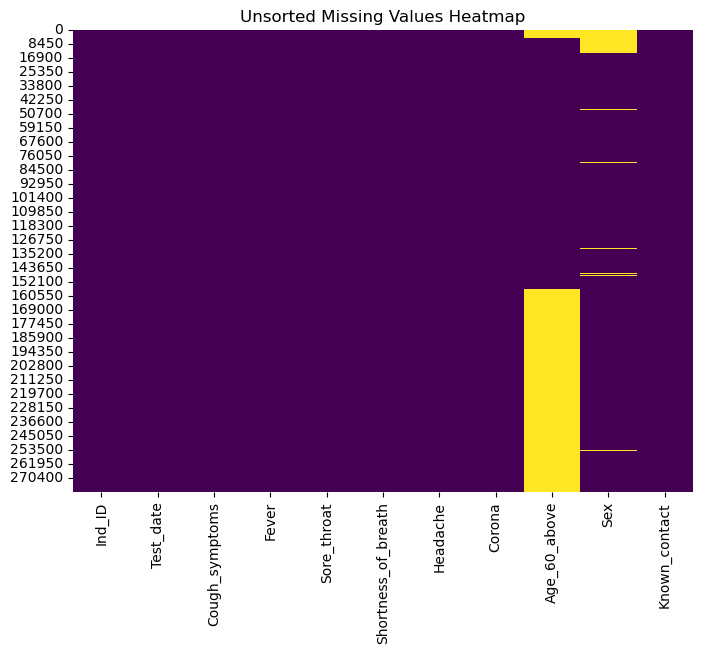

In [4]:
# Exploring Missing Data - ChatGPT 
# Create a boolean DataFrame where True indicates missing values

missing_values = df_original_csv.isnull()

plt.figure(figsize=(8,6))
sns.heatmap(missing_values, cmap='viridis', cbar=False)
plt.title('Unsorted Missing Values Heatmap')
plt.show()

The heatmap shows that the variable "Age_60_above" has a significant amount of missing values. We can also see that the variable "Sex" also has some missing values, but not enough to be alarming. Otherwise, the heatmap shows missing values for the features "Cough_symptoms" and "Fever" as well. We need to find out exactly how many missing values there are in each feature.

The bar plot below provides a comparative visualization of missing values across different features, while excluding the disproportionately affected 'Age_60_above' feature. The decision to exclude the 'Age_60_above' feature from this plot is to prevent its high missing value count from skewing the visualization and obscuring insights into other features.

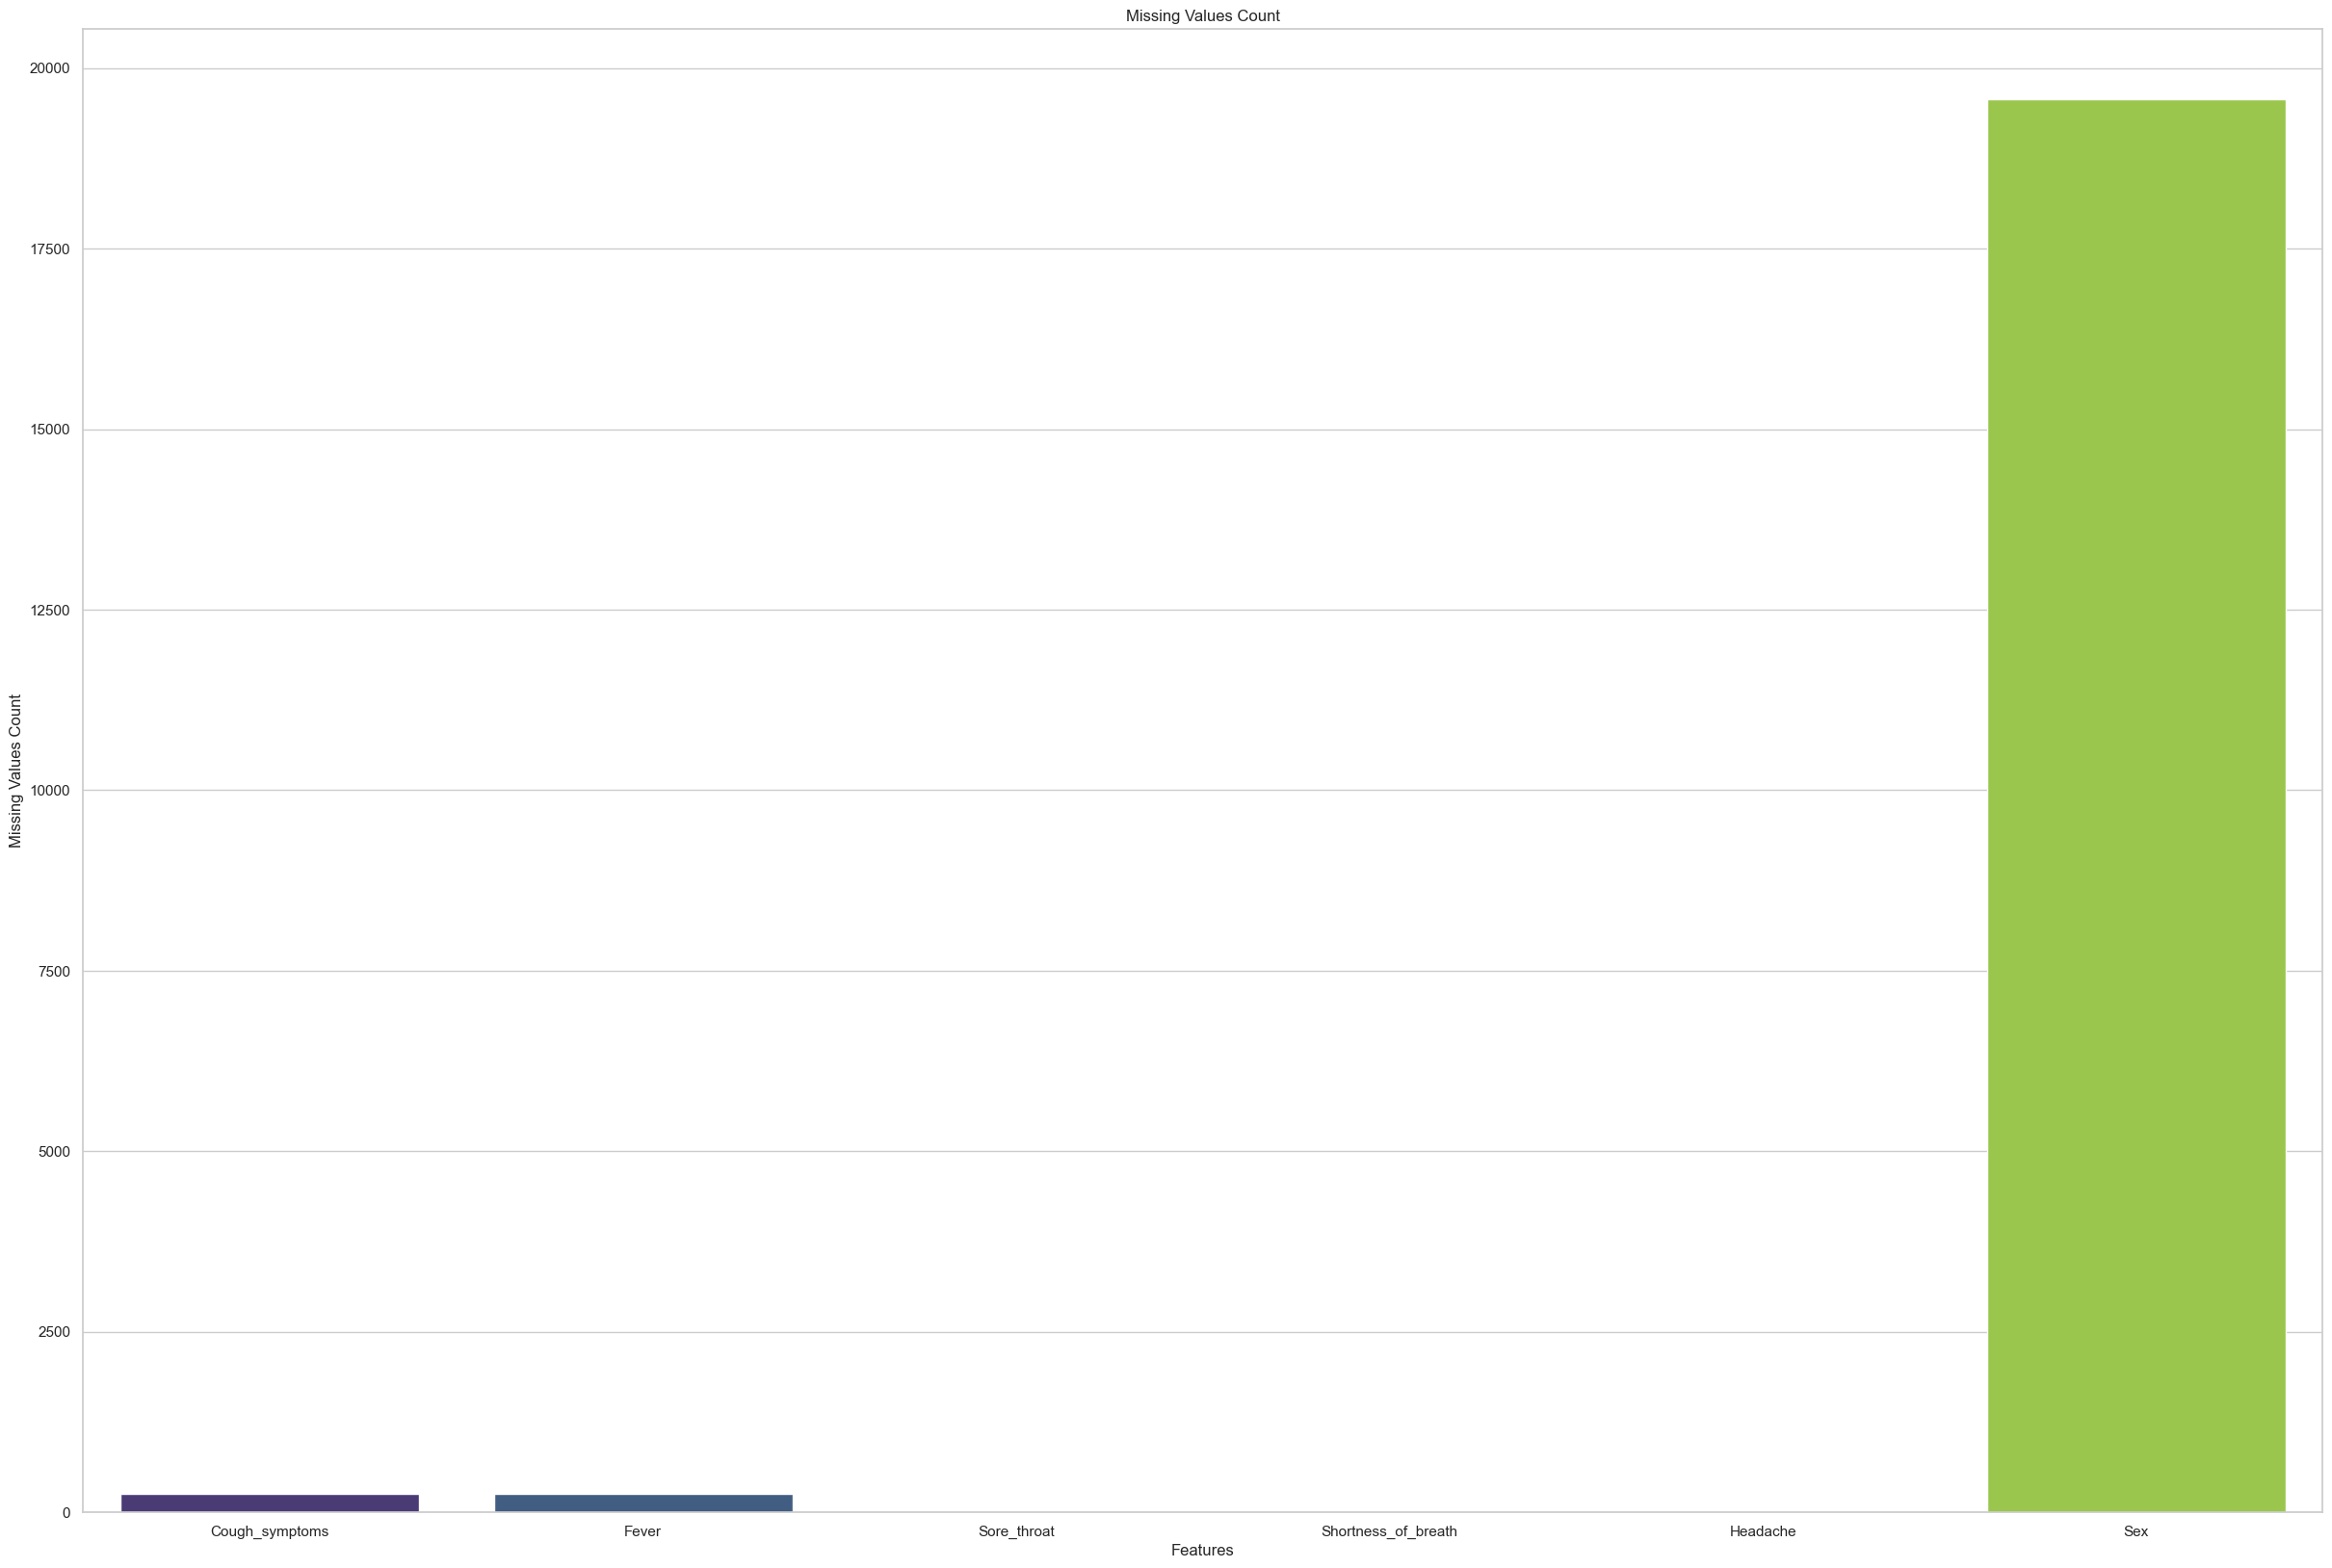

In [5]:
# Bar Plot of missing Values

# Find Missing Values (Sort)
missCount = df_original_csv.isnull().sum()[df_original_csv.isnull().sum() > 0]
# "age_60_above" kind of dwarfs every other variable, with over 100,000 missing values
# Lets plot without that variable
missCount = missCount[missCount > 0].drop(['Age_60_above'])
sns.set(style = "whitegrid")
plt.figure(figsize=(30, 20))
sns.barplot(x = missCount.index, y = missCount.values, palette = "viridis")
plt.title('Missing Values Count')
plt.xlabel('Features')
plt.ylabel('Missing Values Count')
plt.show()

The bar plot only includes features with missing values, meaning features with 1 or more missing values. We can see that "Sex" contains nearly 20,000 missing values, so we will need to choose a preprocessing method to edit or remove those values. "Cough_symptoms" and "Fever" have a few missing values, but less than 100, so we can conclude that simplying removing those instances is sufficient. The same is true for "Sore_throat", "Shortness_of_breath", and "Headache", all of which have a very small number of missing values.

In [6]:
# Removing (Some) Instances with Missing Values
# List of columns to check for missing data, excluding 'Age_60_above'
columns_to_consider = df_original_csv.columns.difference(['Age_60_above'])

# Remove observations with missing data in the specified columns
df_modified = df_original_csv.dropna(subset=columns_to_consider, inplace=False)

# Dataset Size - reduced by the number of dropped instances
row_count, col_count = df_modified.shape
print(f"The dataset contains {row_count} rows and {col_count} columns.")

The dataset contains 259042 rows and 11 columns.


After removing the missing instances in the aforementined columns and removing the column "Age_60_above", we are left with 259,042 rows and 11 columns.

Let's explore "Age_60_above" further. We can calculate the percentage of missing values in the column. 

In [7]:
# Still have about 140,000 missing 'Age_60_above' values
# Calculate the percentage of each unique value in the 'Age_60_above' column
value_counts_percentage = df_modified['Age_60_above'].value_counts(normalize=True, dropna=False) * 100

# Print out the percentages
print("Percentage of each unique value in the 'Age_60_above' column:")
print(value_counts_percentage)

# Unfortunately, we notice that NaN is 46% of the whole column
# In this case, imputation is not an option.

Percentage of each unique value in the 'Age_60_above' column:
Age_60_above
NaN    46.660387
No     44.043823
Yes     9.295790
Name: proportion, dtype: float64


Unfortunately, 48% of the data for "Age_60_above" is missing. In this case, we will remove the entire feature from the dataset because the missing values are too prevalent in the dataset, and imputing may skew the data unintentionally or introduce bias. Furthermore, while 'Age_60_above' might be a strong predictor for whether a person may die from COVID-19, it is likely not a strong predictor for whether or not a person catches COVID-19. 

In [8]:
# Delete the Column 'Age_over_60'
df_modified.drop('Age_60_above', axis=1, inplace=True)
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259042 entries, 13727 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ind_ID               259042 non-null  int64 
 1   Test_date            259042 non-null  object
 2   Cough_symptoms       259042 non-null  object
 3   Fever                259042 non-null  object
 4   Sore_throat          259042 non-null  object
 5   Shortness_of_breath  259042 non-null  object
 6   Headache             259042 non-null  object
 7   Corona               259042 non-null  object
 8   Sex                  259042 non-null  object
 9   Known_contact        259042 non-null  object
dtypes: int64(1), object(9)
memory usage: 21.7+ MB


Next, we identify and remove variables that do not contribute meaningfully to the analysis or predictive modeling, and therefore simplify the dataset.

In predictive modeling for medical outcomes, such as COVID-19 status, the focus is typically on symptoms, test results, and demographic information rather than individual identifiers or dates such as "Ind_ID" or "Test_date". 

In [9]:
 # Delete Unnecessary Columns
df_modified.drop(['Ind_ID', "Test_date"], axis=1, inplace=True)
df_modified.info()

# Dropping Ind_ID because it is a unique identified
# Dropping Test_date because it is not relevant for predicting the COVID status of a person in the future

<class 'pandas.core.frame.DataFrame'>
Index: 259042 entries, 13727 to 278847
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Cough_symptoms       259042 non-null  object
 1   Fever                259042 non-null  object
 2   Sore_throat          259042 non-null  object
 3   Shortness_of_breath  259042 non-null  object
 4   Headache             259042 non-null  object
 5   Corona               259042 non-null  object
 6   Sex                  259042 non-null  object
 7   Known_contact        259042 non-null  object
dtypes: object(8)
memory usage: 17.8+ MB


It is important to understand the distribution of the target variable. This step is important to ensure that the variable is suitably formatted and assess whether the dataset is balanced or skewed towards a certain class. In binary classification tasks, we need to have a target variable with two categories. The presence of the third category necessitates further discussion.

In [10]:
# Let's check the target variable to make sure we have 2 categories
# Calculate the percentage of each unique value in the 'Corona' column
value_counts_percentage = df_modified['Corona'].value_counts(normalize=True, dropna=False) * 100

# Print out the percentages
print("Percentage of each unique value in the 'Corona' column:")
print(value_counts_percentage)

# We have 1.3% "Other" 

Percentage of each unique value in the 'Corona' column:
Corona
negative    93.473645
positive     5.223863
other        1.302491
Name: proportion, dtype: float64


The presence of the "Other" class could represent a class that is not clearly positive or negative, or it could be a placeholder for missing data. 

We have a few options. 

Options:

- Replace with Positive or Negative: If "Other" is determined to be similar to "positive" or "negative" cases based on domain knowledge or data patterns, we can recode it accordingly. This is a strong assumption and could skew results if not done with proper justification.

- Delete the Rows: If "Other" cannot be reliably classified as either "positive" or "negative," and if its inclusion is not critical to the analysis, it may be simplest to remove these rows from the dataset.

- Impute: If there's a systematic way to impute "Other" based on other features in the dataset, this could be an option. However, this can be complex and requires a strong justification.

Our Approach to Decide:

We are going to perform an analysis of the nature of these "Other" observations. We will perform a cluster analysis to see if the "Other" cases group with "positive" or "negative" cases, to see if replacing "Other" with "positive" or "negative" is feasible. 

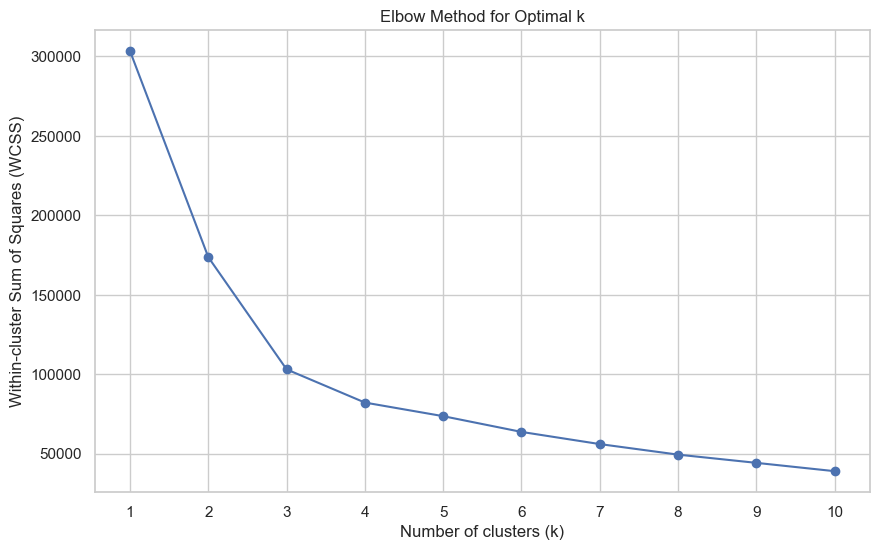

In [11]:
from sklearn.cluster import KMeans

df_cluster_purpose = df_modified.copy()

encoder = OneHotEncoder()

# Apply the encoder to the categorical data, excluding the 'Corona' target variable
df_encoded = encoder.fit_transform(df_cluster_purpose.drop(columns='Corona'))

df_encoded_array = df_encoded.toarray()

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # Within-cluster sum of squares

# Determine the range of k values to try
# We'll try k from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_encoded_array)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for KMeans

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

First, we need to decide the optimal number of clusters for a K-Means cluster analysis. We tried 1-10 clusters to output the scree plot above. Based on the location of the knee, we decide that 3 clusters is optimal for this situation. 

Let's take a look at the distribution of "Corona" classes when we choose the number of clusters to be 3. 

In [12]:
# Choose the number of clusters to be 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_encoded_array)

# Add the cluster labels back to the DataFrame
df_cluster_purpose['Cluster'] = clusters

# ChatGPT helped generate the code below:
# See the distribution of 'Corona' categories within each cluster:
cluster_distribution = df_cluster_purpose.groupby('Cluster')['Corona'].value_counts(normalize=True) * 100

print("Cluster distribution for each 'Corona' category:")
print(cluster_distribution)

Cluster distribution for each 'Corona' category:
Cluster  Corona  
0        negative    83.336150
         positive    15.123270
         other        1.540579
1        negative    95.000328
         positive     3.679093
         other        1.320580
2        negative    95.790832
         positive     3.013125
         other        1.196043
Name: proportion, dtype: float64


The output from the clustering analysis provides insight into how the cases labeled as "negative", "positive", and "other" in the 'Corona' column are distributed across the three clusters identified by the K-Means algorithm.

Cluster 0 contains a significant portion of negative cases, and contains a considerable representation of positive cases (15.12%). Cluster 0 contains a small fraction of Other cases.

Cluster 1 is also dominated by negative cases and positive cases are less prevalent than in Cluster 0. Other cases are, predictably, once again the smallest group.

Cluster 2 is similar in distribution to Cluster 1 with a high prevalance of negative cases and only 3% of positive cases. Other cases are present only slightly less often than in Cluster 1. 

From these statistics, we can say that Cluster 0 captures a different profile that is more associated with positive cases, while the other two clusters are skewed towards negative cases. 

However, the presence of Other cases in all 3 clusters indicates that they do not form a distinct cluster of their own. They seem to not have a distinct or consistent set of features that separates them clearly from the positive or negative cases. 

Dominant category for Cough_symptoms in each cluster:
0     Cough_symptoms_True
1    Cough_symptoms_False
2    Cough_symptoms_False
dtype: object
Dominant category for Fever in each cluster:
0    Fever_False
1    Fever_False
2    Fever_False
dtype: object
Dominant category for Sore_throat in each cluster:
0    Sore_throat_False
1    Sore_throat_False
2    Sore_throat_False
dtype: object
Dominant category for Shortness_of_breath in each cluster:
0    Shortness_of_breath_False
1    Shortness_of_breath_False
2    Shortness_of_breath_False
dtype: object
Dominant category for Headache in each cluster:
0    Headache_False
1    Headache_False
2    Headache_False
dtype: object
Dominant category for Sex in each cluster:
0      Sex_male
1      Sex_male
2    Sex_female
dtype: object
Dominant category for Known_contact in each cluster:
0    Known_contact_Abroad
1     Known_contact_Other
2     Known_contact_Other
dtype: object
No related columns found for feature Cluster.


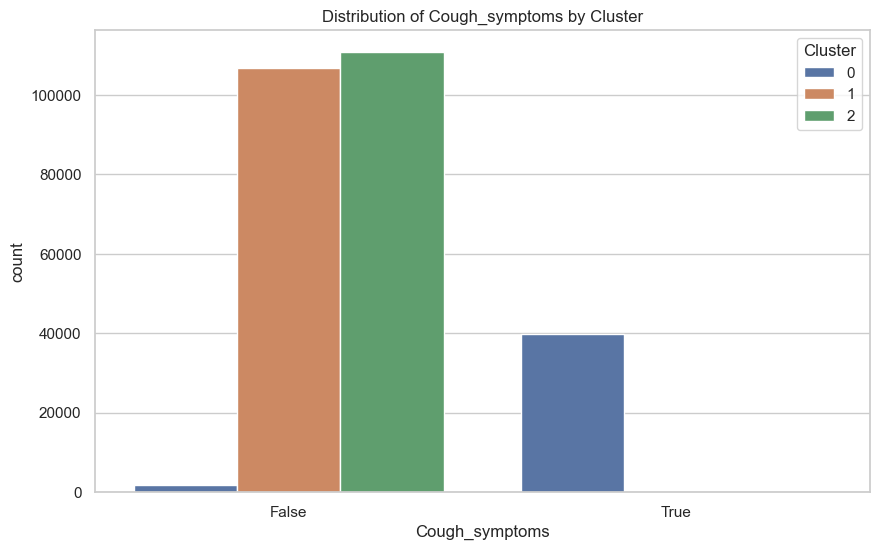

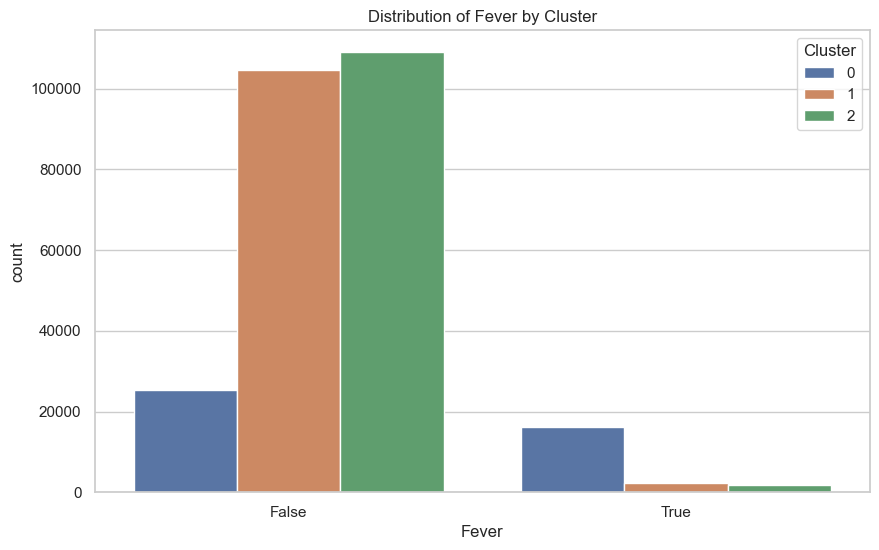

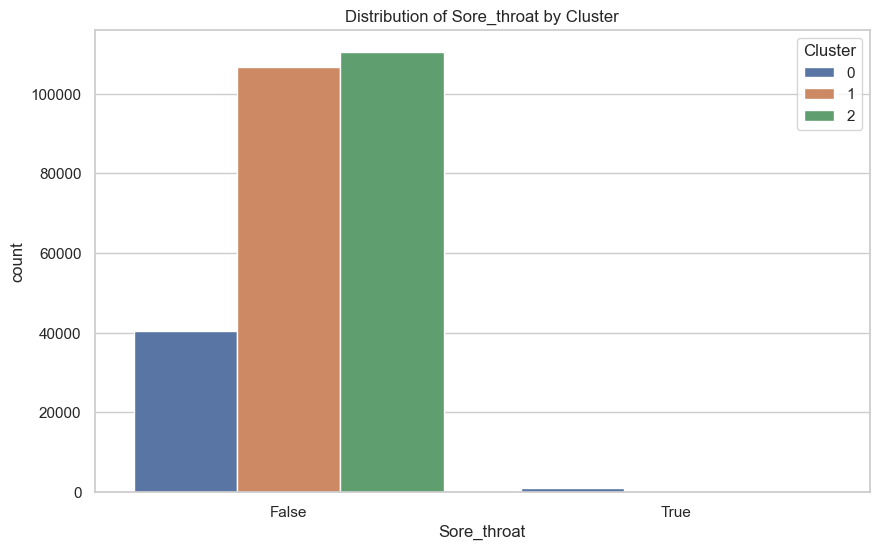

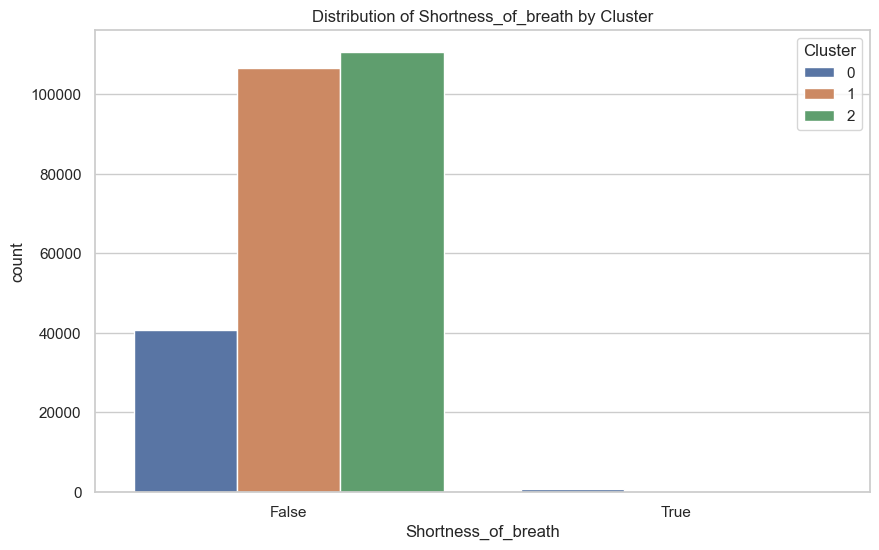

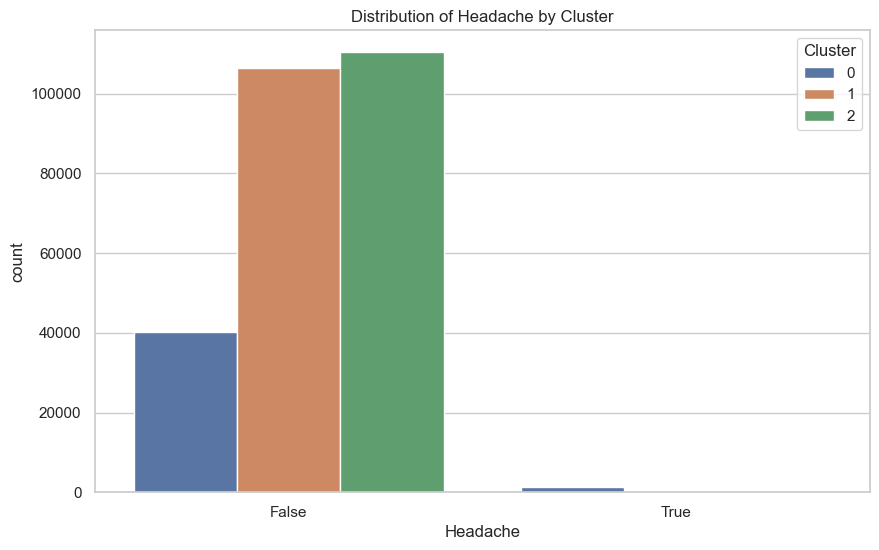

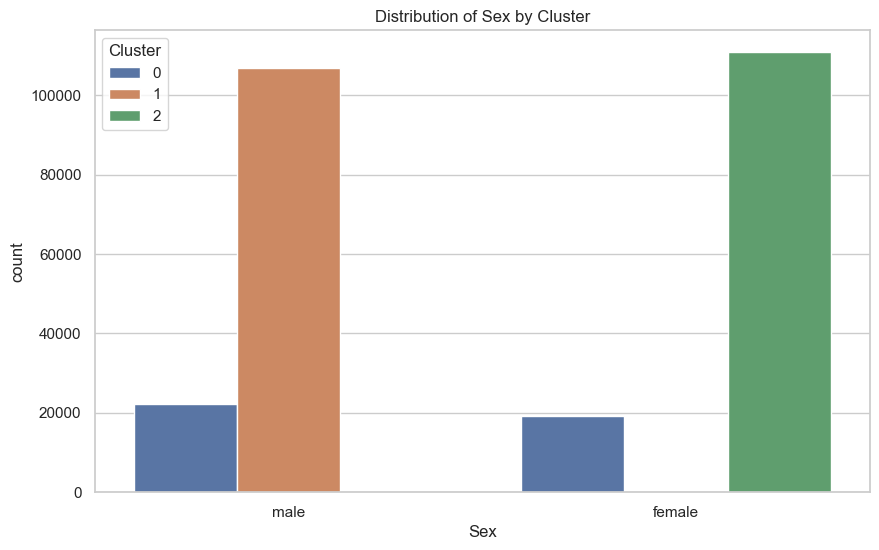

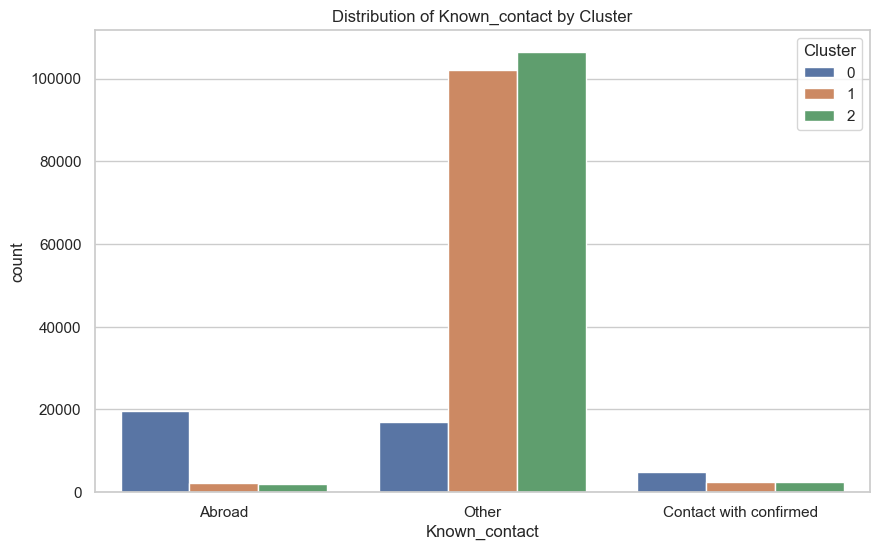

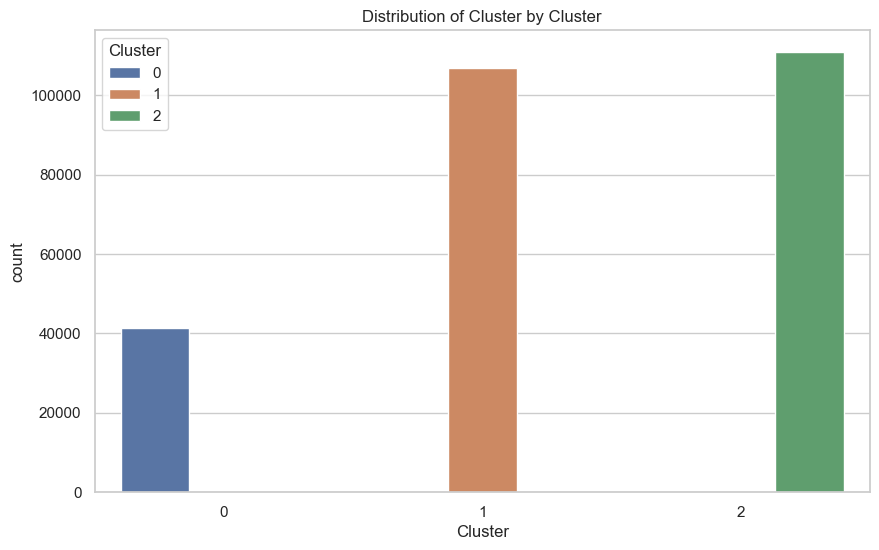

In [13]:
# Using the KMeans that we called .fit() on earlier
centroids = kmeans.cluster_centers_

# For scikit-learn 0.22 and newer
if hasattr(encoder, 'get_feature_names_out'):
    # Use get_feature_names_out for scikit-learn 0.22 and later
    original_feature_names = encoder.get_feature_names_out()
else:
    # Fallback for older versions, manually create feature names
    original_feature_names = []
    for i, cat in enumerate(encoder.categories_):
        original_feature_names.extend([f"{df_cluster_purpose.drop(columns='Corona').columns[i]}_{c}" for c in cat])

# Create a DataFrame with the centroids and the feature names
centroids_df = pd.DataFrame(centroids, columns=original_feature_names)

# Interpret the centroids
for feature in df_cluster_purpose.drop(columns='Corona').columns:
    # Find the columns corresponding to the feature
    related_cols = [col for col in centroids_df.columns if col.startswith(feature)]
    
    if related_cols:  # Ensure the list is not empty
        # Get the centroid values for these columns
        centroid_feature_values = centroids_df[related_cols]
        
        if not centroid_feature_values.empty:
            # Identify the highest value in each cluster's set of values for this feature
            dominant_category = centroid_feature_values.idxmax(axis=1)
            print(f"Dominant category for {feature} in each cluster:")
            print(dominant_category)
        else:
            print(f"No data available to determine the dominant category for {feature}.")
    else:
        print(f"No related columns found for feature {feature}.")


# Use count plots to visualize the distribution of categorical features within clusters
for col in df_cluster_purpose.drop(columns='Corona').columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Cluster', data=df_cluster_purpose)
    plt.title(f'Distribution of {col} by Cluster')
    plt.show()

It seems like Cluster 0 consistently had a higher "True" value for both risk factors "Abroad" and "Known contact" as well as for each symptom. Cluster 0 also has the highest percentage of positive cases compared to Clusters 1 and 2. 

Let's break down the distribution within clusters so that we aren't misled by the overwhelming negative cases. 

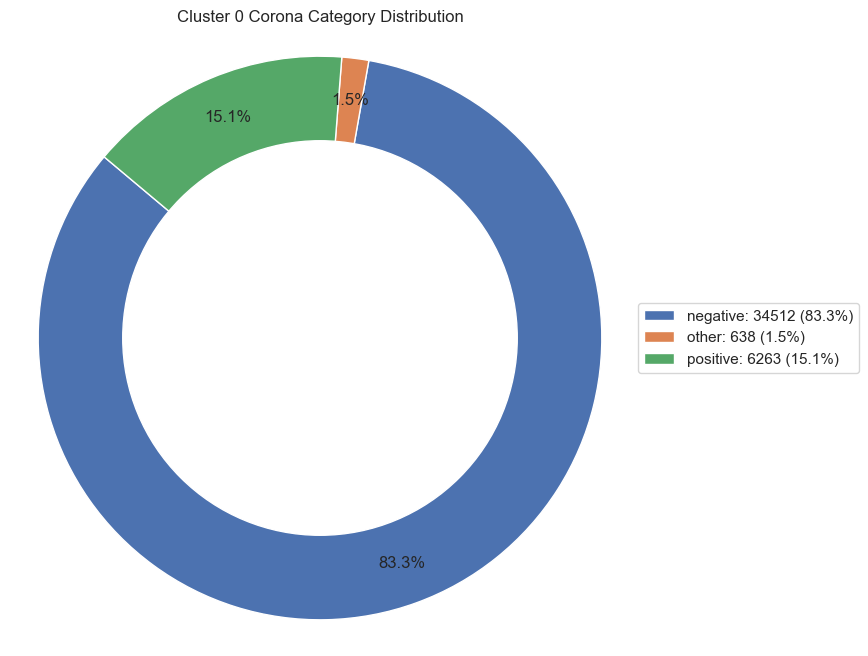

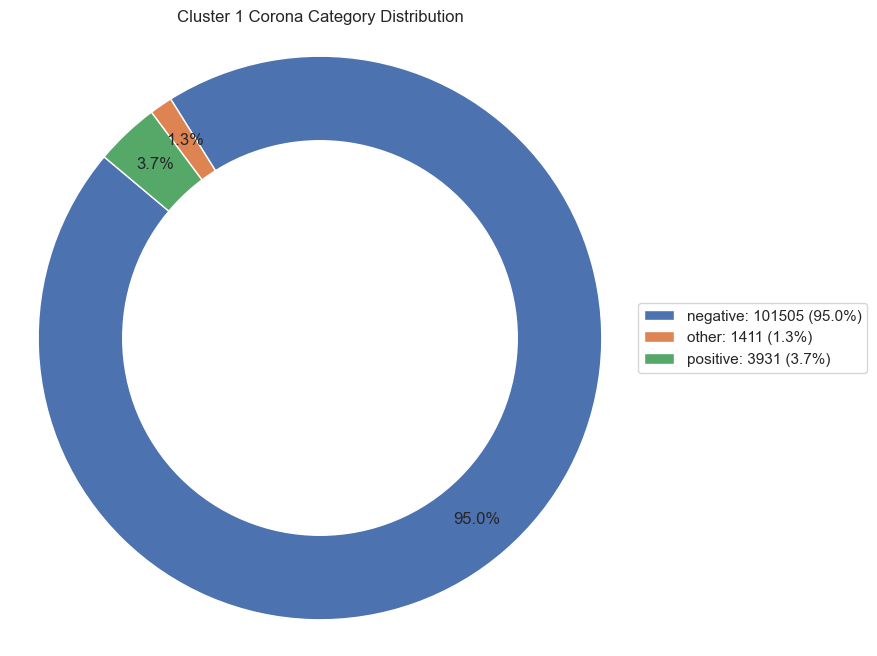

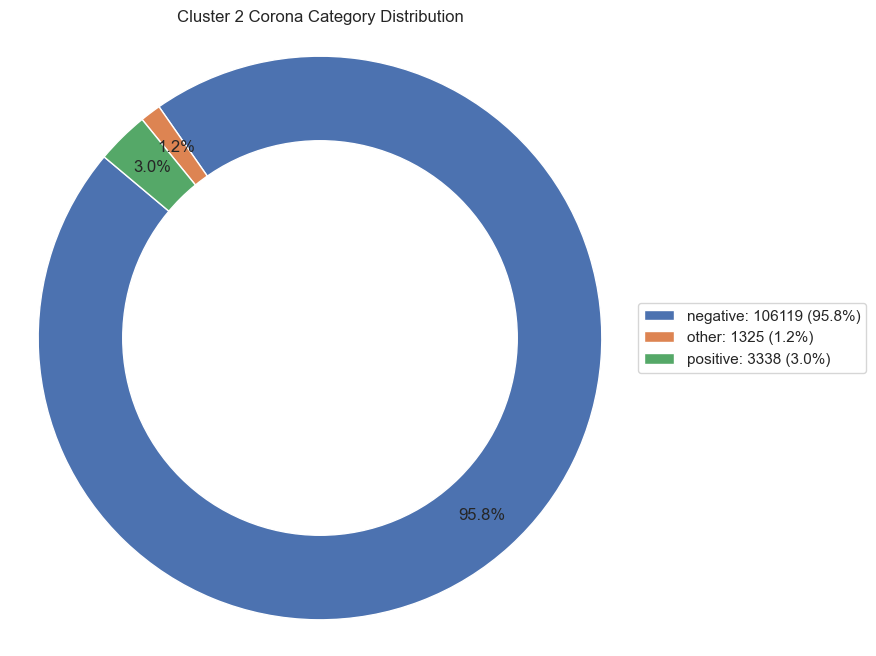

In [14]:
# Calculate the count of each 'Corona' category within each cluster
cluster_category_distribution = df_cluster_purpose.groupby(['Cluster', 'Corona']).size().unstack(fill_value=0)

# Plot a pie chart for each cluster with custom legend labels showing both count and percentage
for cluster in cluster_category_distribution.index:
    # Get the count and percentage for each 'Corona' category in the cluster
    counts = cluster_category_distribution.loc[cluster]
    total_count = counts.sum()
    percentages = (counts / total_count) * 100

    # Create custom labels for the legend
    labels = [f'{category}: {count} ({percentage:.1f}%)' for category, count, percentage in zip(counts.index, counts, percentages)]

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    pie_wedges = plt.pie(counts, startangle=140, autopct='%1.1f%%', pctdistance=0.85)
    
    # Draw a circle at the center to make it a donut chart
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # Add the legend with the custom labels
    plt.legend(pie_wedges[0], labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')
    plt.title(f'Cluster {cluster} Corona Category Distribution')
    plt.show()

18.90% (638/3374) of the "Other" values fall into Cluster 0, with majority negative cases, but 46.28% (6,263/13,532) of the "positive" values also fall into Cluster 0. That is nearly half of the positive cases in the same cluster as almost 19% of the "Other" values. While most of the "other" values fall into a cluster with less than 5% of positive cases, the 19% of "other" values that do not tells us that representing "other" as "negative" is not an option. The chance of a false negative would be too great in such a health context. 

It would be unwise to not consider the medical implications. If "Other" does in fact refer to an "inconclusive" test result, then categorizing "Other" cases as "positive" in the context of a pandemic response would be a more cautious approach. A common public health practice to prevent the spread from those who might be infectious but have not yet been confirmed is to treat inconclusive tests as positive until proven otherwise. 

We assume that the "Other" response is an inconclusive test because there are no NaNs in the "Corona" column, which might have indicated data unavaliability, as was the case for other features. 

Since deleting instances is a last resort, especially when dealing with a dataset that has health implications, and the dataset already has an imbalance issue between positive and negative cases, further removing the data could exacerbate the issue. 

In this case, to minimize the risk of false negatives, we will reclassify them as "positive" in order to err on the side of caution.

In [15]:
# Replace "Other" with "Positive" in target variable
df_modified['Corona'] = df_modified['Corona'].replace('other', 'positive')
df_modified['Corona'].unique()

array(['negative', 'positive'], dtype=object)

We have dealt with missing values! Now let's explore what kind of values we do have, and see how they are distributed to identify potential class imbalance issues. 

In [16]:
# ChatGPT generated this code so that it prints nicely!
for i in ['Cough_symptoms', 'Fever', 'Sore_throat',
          'Shortness_of_breath', 'Headache', 'Corona', 'Sex',
          'Known_contact']:
    print("The unique values and their percentage in '{}' are: ".format(i))
    value_counts = df_modified[i].value_counts(normalize=True, dropna=False) * 100
    for value, percentage in value_counts.items():
        print(f"  {value}: {percentage:.2f}%")
    print("-"*100)

The unique values and their percentage in 'Cough_symptoms' are: 
  False: 84.69%
  True: 15.31%
----------------------------------------------------------------------------------------------------
The unique values and their percentage in 'Fever' are: 
  False: 92.20%
  True: 7.80%
----------------------------------------------------------------------------------------------------
The unique values and their percentage in 'Sore_throat' are: 
  False: 99.41%
  True: 0.59%
----------------------------------------------------------------------------------------------------
The unique values and their percentage in 'Shortness_of_breath' are: 
  False: 99.58%
  True: 0.42%
----------------------------------------------------------------------------------------------------
The unique values and their percentage in 'Headache' are: 
  False: 99.18%
  True: 0.82%
----------------------------------------------------------------------------------------------------
The unique values and their perc

From the output above, we see that the "False" values overwhelmingly outnumber the "True" values for every category of symptom. In the case of "Known Contact", the category "Other" dwarfs the other categories with 87% majority value. In the category "Sex", the distribution of Female and Male instances is about the same. Finally, in the "Corona" category as we discovered earlier, there is a massive imbalance where 93.47% of the instances are negative cases, and only 6.53% of instances are positive cases. These positive cases include the reclassified cases that were originally "Other".

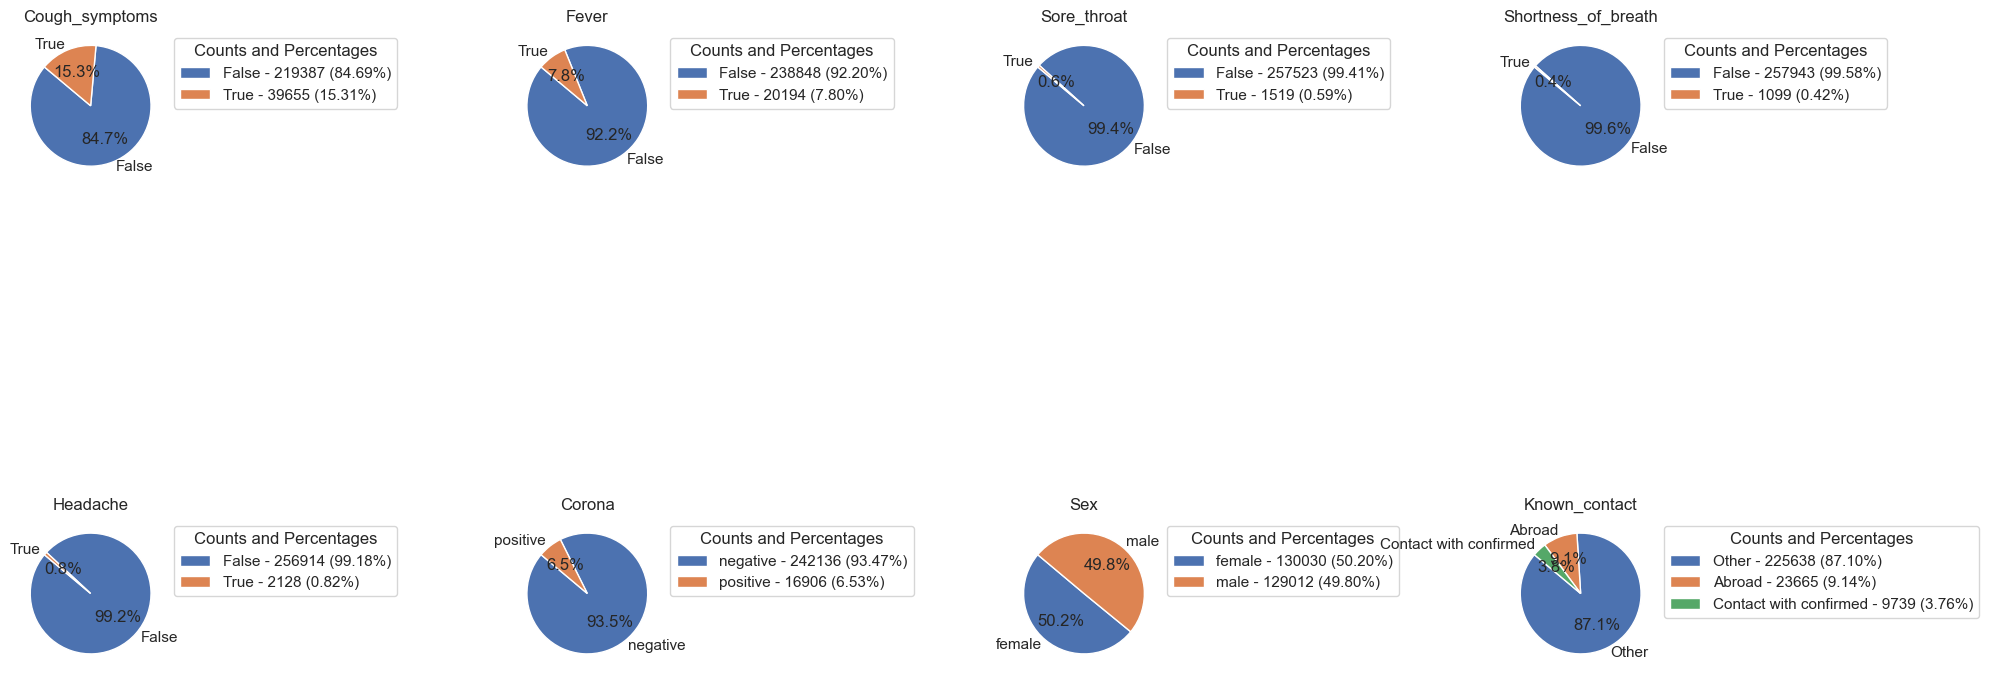

In [17]:
# Explore Unique Values in Each Column
# Set the number of rows and columns for the subplot grid
r = 2  # 2 rows
c = 4  # 4 columns

it = 1  # Initializing subplot counter

# Set the figure size (optional, you can adjust it as needed)
plt.figure(figsize=(20, 10))

for i in df_modified.columns:
    plt.subplot(r, c, it)
    # Calculate the counts and percentages for the current column
    counts = df_modified[i].value_counts()
    percentages = (counts / counts.sum()) * 100
    # Combine counts and percentages for the legend
    labels = [f'{index} - {count} ({percentage:.2f}%)' for index, count, percentage in zip(counts.index, counts, percentages)]
    # Plot pie chart
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(i)
    # Place a legend on the chart
    plt.legend(labels, title="Counts and Percentages", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
    it += 1

plt.tight_layout()
plt.show()

Above is a visual representation of the output showing the distribution of each class within each feature after reclassifying "Other" as "Positive" for the target variable "Corona". 

Let's finish preparing the data by one-hot encoding our 8 categorical features. 

In [18]:
# One-hot encode the categorical features and ensure the dtype is integer
df_modified = pd.get_dummies(df_modified, columns=df_modified.columns, dtype=int)

# 'corona_positive' is 1 if positive and 0 otherwise
# 'corona_negative' is 1 if negative and 0 otherwise
# We want to create a single column 'Corona' that is 1 for positive and 0 for negative

df_modified['Corona'] = df_modified['Corona_positive']

# Now drop the one-hot encoded columns
df_modified.drop(['Corona_negative', 'Corona_positive'], axis=1, inplace=True)
df_modified.reset_index(inplace=True)
df_modified.drop(['index'], axis=1, inplace=True)

# Display the first few rows of the encoded DataFrame to verify the dtypes
df_modified.head()

,Cough_symptoms_False,Cough_symptoms_True,Fever_False,Fever_True,Sore_throat_False,Sore_throat_True,Shortness_of_breath_False,Shortness_of_breath_True,Headache_False,Headache_True,Sex_female,Sex_male,Known_contact_Abroad,Known_contact_Contact with confirmed,Known_contact_Other,Corona
0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0
1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0
2,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1
3,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1
4,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1


In [19]:
# Final Check
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259042 entries, 0 to 259041
Data columns (total 16 columns):
 #   Column                                Non-Null Count   Dtype
---  ------                                --------------   -----
 0   Cough_symptoms_False                  259042 non-null  int64
 1   Cough_symptoms_True                   259042 non-null  int64
 2   Fever_False                           259042 non-null  int64
 3   Fever_True                            259042 non-null  int64
 4   Sore_throat_False                     259042 non-null  int64
 5   Sore_throat_True                      259042 non-null  int64
 6   Shortness_of_breath_False             259042 non-null  int64
 7   Shortness_of_breath_True              259042 non-null  int64
 8   Headache_False                        259042 non-null  int64
 9   Headache_True                         259042 non-null  int64
 10  Sex_female                            259042 non-null  int64
 11  Sex_male                  

In [20]:
df_modified.head()

,Cough_symptoms_False,Cough_symptoms_True,Fever_False,Fever_True,Sore_throat_False,Sore_throat_True,Shortness_of_breath_False,Shortness_of_breath_True,Headache_False,Headache_True,Sex_female,Sex_male,Known_contact_Abroad,Known_contact_Contact with confirmed,Known_contact_Other,Corona
0,0,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0
1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0
2,0,1,0,1,1,0,1,0,1,0,1,0,0,0,1,1
3,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1
4,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1


Now, in creating a DataFrame that will work well with Keras and its built-in `FeatureSpace`, functionality, we will adjust our code to make this happen.

In [21]:
df_for_feature_space = pd.DataFrame()

def yes_if_1(cell: int) -> str:
    return "yes" if cell == 1 else "no"

# Input the simple yes/no questions into the dataframe
df_for_feature_space["has_cough_symptoms"] = df_modified["Cough_symptoms_True"].apply(yes_if_1)
df_for_feature_space["has_fever"] = df_modified["Fever_True"].apply(yes_if_1)
df_for_feature_space["has_sore_throat_symptoms"] = df_modified["Sore_throat_True"].apply(yes_if_1)
df_for_feature_space["has_shortness_of_breath"] = df_modified["Shortness_of_breath_True"].apply(yes_if_1)
df_for_feature_space["has_headache"] = df_modified["Headache_True"].apply(yes_if_1)

# Input sex variable
row_count = df_for_feature_space.shape[0]
all_sexes = np.full((row_count,1), "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

for i in range(row_count):
    if df_modified.loc[i,"Sex_male"] == 1:
        all_sexes[i,0] = "male"
    elif df_modified.loc[i,"Sex_female"] == 1:
        all_sexes[i,0] = "female"
    else:
        all_sexes[i,0] = "other"

df_for_feature_space["sex"] = all_sexes[:,0]

# Known contact column
known_contact = np.full((row_count,1), "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

for i in range(row_count):
    if df_modified.loc[i,"Known_contact_Contact with confirmed"] == 1:
        known_contact[i,0] = "confirmed_contact"
    elif df_modified.loc[i,"Known_contact_Abroad"] == 1:
        known_contact[i,0] = "abroad"
    else:
        known_contact[i,0] = "yes"

df_for_feature_space["contact_with_confirmed_case"] = known_contact[:,0]


# Tested positive for COVID-19
df_for_feature_space["tested_positive_for_covid"] = df_modified["Corona"]

# Display contents
df_for_feature_space.head()

,has_cough_symptoms,has_fever,has_sore_throat_symptoms,has_shortness_of_breath,has_headache,sex,contact_with_confirmed_case,tested_positive_for_covid
0,yes,no,no,no,no,male,abroad,0
1,yes,no,no,no,no,female,abroad,0
2,yes,yes,no,no,no,female,yes,1
3,no,no,no,no,no,female,yes,1
4,no,no,no,no,no,female,yes,1


In [22]:
df_for_feature_space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259042 entries, 0 to 259041
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   has_cough_symptoms           259042 non-null  object
 1   has_fever                    259042 non-null  object
 2   has_sore_throat_symptoms     259042 non-null  object
 3   has_shortness_of_breath      259042 non-null  object
 4   has_headache                 259042 non-null  object
 5   sex                          259042 non-null  object
 6   contact_with_confirmed_case  259042 non-null  object
 7   tested_positive_for_covid    259042 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 15.8+ MB


In [23]:
df = df_for_feature_space.copy()

### **1.2: identify groups of features for cross-product features**


Given the nature of COVID-19 as a respiratory illness that exhibits a multitiude of symptoms depending on the person infected, certain symptoms can be highly correlated with the likelihood of a positive test result when they occur together. For instance, crossing `has_cough_symptoms` with `has_fever` could be particularly insightful because these symptoms are common indicators of respiratory illnesses, including COVID-19. This crossed feature could help the model learn the combined predictive power of these symptoms.

Another valuable cross could be between `has_shortness_of_breath` and `has_sore_throat_symptoms`. Shortness of breath is a more severe symptom that is less common in other respiratory diseases but prevalent in COVID-19 cases according to <a href="https://ada.com/covid/covid-19-shortness-of-breath/">ADA</a>, especially symptomatic ones. When coupled with sore throat symptoms, it might indicate a higher likelihood of a COVID-19 infection.

The feature `contact_with_confirmed_case` is a critical predictor on its own. When crossed with any symptom feature, it could significantly enhance the model's ability to predict positive cases,. The assumption is that symptoms in the presence of known contact with a confirmed case may be more indicative of COVID-19 than the same symptoms without such contact. Regarding demographic data, sex might interact with symptoms and contact history differently. It may be worth exploring crosses like sex with `has_cough_symptoms` or sex with `contact_with_confirmed_case` to capture any gender-specific patterns in the spread or reporting of the disease.

### **1.3: Choose and Explain the Metric(s) to use to evaluate the algorithm's performance**

Because of our class imbalance problem, accuracy would be a terribly misleading performance metric. Accuracy would hide our model's potentially imbalanced, over-predictive tendencies to choose negative cases in monents where cases are truly positive and vice versa. 

In the context of COVID-19 testing, where the consequences of missing a positive case can be severe due to potential spread and health complications, the recall of the test is crucial. The recall measures the ability of a test to correctly identify all positive cases. However, precision cannot be ignored entirely as false positives can lead to unnecessary anxiety, strain on healthcare systems, and economic consequences if individuals are wrongly advised to isolate.

The F-beta score is a weighted harmonic mean of precision and recall, with the beta parameter determining the weight of recall in the combined score. An F-beta score with a beta of 2 (F2 score) places more emphasis on recall than precision, which means that it penalizes false negatives more than false positives but also doesn't ignore them entirely. This is aligned with the priority in the context of a disease that causes serious health implications, where the cost of false negatives (failing to identify a positive case) is typically higher than the cost of false positives (incorrectly identifying a case as positive).

 While recall is prioritized, precision is not ignored. An F2 score still incorporates precision, which helps to control the number of false positives. This is important to avoid overwhelming the healthcare system with people who are not actually infected and to maintain public trust in the testing process. By using the F2 score, there is flexibility to adjust the decision threshold of the model to increase recall without excessively penalizing the precision, allowing for a more nuanced approach to balancing the trade-offs between missing actual cases and causing undue alarm.

### **1.4: Choose the method you will use to conduct train/test split**


We need to consider a few things:
- Stratification: The target variable is large and binary and has a significant class imbalance. We need to maintain the proportion of each class in both training and testing sets. 
- The split should be random.
- We opt to do a 80-20 train-test split.

Stratification ensures that each split of the data has the same proportion of class labels as the original dataset. This is crucial when dealing with imbalanced datasets where one class significantly outnumbers the others. Without stratification, there's a risk that a random split could result in a data set with a disproportionately low number of samples from the minority class, which could bias the training process and the evaluation of the model. Especially in the context of COVID-19 testing where people who go to test will likely be negative more times than not, and given that the dataset we have that is heavily imbalanced, we will make sure to employ stratification in doing a train-test split. 

Shuffling is a process of randomly permuting (shuffling) the data before splitting. This is important to remove any potential bias or order that might be present in the dataset. Ensuring randomness in choice of data, especially when we also need to stratify and randomness could sometimes be lost in these contexts, is essential for ensuring statistical validity and that our data we train a model on and validate our model on is representative. For example, if the data is sorted by the target variable or any feature, models could learn patterns that are a result of this ordering rather than the underlying relationships between features and the target variable.

The `StratifiedShuffleSplit` combines these two to ensure that every split has the same class distribution as the whole dataset, while also introducing randomness through shuffling to ensure that the training and testing sets are random samples of the data.

In [24]:
df.shape

(259042, 8)

Additionally, we will not employ $k$-fold cross-validation, because we have a lot of data (259,042 rows). This is significant, because despite our class imbalance, we have an extremely large quantity of training and testing data to be able to use regardless, which makes it so it's not necessary to perform cross validation. A single stratified shuffle split can provide us with a a sufficiently large validation set that can give a good estimate of how well our model will perform on unseen data.

### **1.5: Implement Code for Descriptions Above and Incorporating Tensorflow and Keras**

First, we will input our data all into a `tf.data.Dataset` class and employ Stratified Shuffle Split when doing this. 

In [25]:
# We adjusted it a lot, but ChatGPT gave us some inspiration for employing 
# the StratifiedShuffleSplit and how it fits in with the tf.data.Dataset inputting.

# Function to create a tf.data.Dataset from a DataFrame
def df_to_dataset(dataframe: pd.DataFrame, shuffle=True, batch_size=32) -> tf.data.Dataset:
    dataframe = dataframe.copy()
    labels = dataframe.pop('tested_positive_for_covid')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

# Define StratifiedShuffleSplit with a single split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# X is all the columns except the label, and y is just the label.
X = df.drop("tested_positive_for_covid", axis=1)
y = df["tested_positive_for_covid"]

# Perform the split
train_index, test_index = next(sss.split(X, y))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Create DataFrames for the single split
df_train = X_train.copy()
df_train["tested_positive_for_covid"] = y_train

df_test = X_test.copy()
df_test["tested_positive_for_covid"] = y_test

# Convert the train and test DataFrames to tf.data.Dataset
ds_train = df_to_dataset(df_train, shuffle=True, batch_size=32)
ds_test = df_to_dataset(df_test, shuffle=False, batch_size=32)

2023-11-12 21:56:38.489464: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-12 21:56:38.489510: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-12 21:56:38.489522: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-12 21:56:38.489746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-12 21:56:38.489785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
# here is an example of what the data looks like from this class
[(feat,label)] = ds_train.take(1)
print(feat.keys())
print(label) # print out a batch of the labels 

dict_keys(['has_cough_symptoms', 'has_fever', 'has_sore_throat_symptoms', 'has_shortness_of_breath', 'has_headache', 'sex', 'contact_with_confirmed_case'])
tf.Tensor([0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)


Now we will create feature spaces with Keras that reflect the crosses we want to incorporate in to our model. For the first feature space without any crossed features:

In [27]:
# Make the first feature space not have a single cross feature
feature_space_1 = FeatureSpace(
    # Input string categorical features
    features={
        "has_cough_symptoms": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_fever": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_sore_throat_symptoms": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_shortness_of_breath": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_headache": FeatureSpace.string_categorical(num_oov_indices=0),
        "sex": FeatureSpace.string_categorical(num_oov_indices=0),
        "contact_with_confirmed_case": FeatureSpace.string_categorical(num_oov_indices=0),
    },
    # Showcase the output mode
    output_mode="concat",
)

# now that we have specified the preprocessing, let's run it on the data
train_ds_with_no_labels_1 = ds_train.map(lambda x, _: x)
feature_space_1.adapt(train_ds_with_no_labels_1)

preprocessed_ds_train_1 = ds_train.map(lambda x, y: (feature_space_1(x), y), 
                                       num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train_1 = preprocessed_ds_train_1.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test_1 = ds_test.map(lambda x, y: (feature_space_1(x), y), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test_1 = preprocessed_ds_test_1.prefetch(tf.data.AUTOTUNE)

2023-11-12 21:56:43.176796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 21:56:49.774270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 21:56:56.217157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 21:57:02.527361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 21:57:09.488968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 21:57:16.660408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 21:57:23.164490: I tensorflow/core/grappler/optimizers/cust

Now, for the feature space with cross features that rely on relationships between symptom variables and demographic variables we previously established may exist in the COVID data.

In [28]:
# Make the first feature space not have a single cross feature
feature_space_2 = FeatureSpace(
    # Input string categorical features
    features={
        "has_cough_symptoms": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_fever": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_sore_throat_symptoms": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_shortness_of_breath": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_headache": FeatureSpace.string_categorical(num_oov_indices=0),
        "sex": FeatureSpace.string_categorical(num_oov_indices=0),
        "contact_with_confirmed_case": FeatureSpace.string_categorical(num_oov_indices=0),
    },
    # Specify feature cross with a custom crossing dimensions
    crosses=[
        # Check mix of symptoms and how they affect COVID test result
        FeatureSpace.cross(
            feature_names=("has_cough_symptoms", "has_fever"), # dims: 5 x 5
            crossing_dim=5*5,
        ),
        FeatureSpace.cross(
            feature_names=("has_shortness_of_breath", "has_sore_throat_symptoms"), # dims: 5 x 5 = 
            crossing_dim=5*5,
        ),
        # Check mix of symptom and contact with confirmed case and how they affect COVID test result
        FeatureSpace.cross(
            feature_names=("has_cough_symptoms", "contact_with_confirmed_case"), # dims: 5 x 10 = 
            crossing_dim=5*10,
        ),
        # Check sex and contact with confirmed case and how they affect COVID test result
        ## This liklely won't be very affective in our opinion because we don't see sex
        ## being influential here, but we still wanted to check just in case
        FeatureSpace.cross(
            feature_names=("sex", "contact_with_confirmed_case"), # dims: 2 x 4 = 
            crossing_dim=2*4,
        ),
    ],
    # Showcase the output mode
    output_mode="concat",
)

# now that we have specified the preprocessing, let's run it on the data
train_ds_with_no_labels_2 = ds_train.map(lambda x, _: x)
feature_space_2.adapt(train_ds_with_no_labels_2)

preprocessed_ds_train_2 = ds_train.map(lambda x, y: (feature_space_2(x), y), 
                                       num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train_2 = preprocessed_ds_train_2.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test_2 = ds_test.map(lambda x, y: (feature_space_2(x), y), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test_2 = preprocessed_ds_test_2.prefetch(tf.data.AUTOTUNE)

2023-11-12 16:12:51.595178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:12:57.749508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:03.489389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:09.393675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:15.108573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:20.683195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:26.332934: I tensorflow/core/grappler/optimizers/cust

The final feature space that we will use and incorporate into our model will just be the same as the one above but without the cross features that involve and incorporate the `contact_with_confirmed_case` column. The reasoning for this is to just factor in cross features that have symptom relationships crossed between each other and see how the model performs in comparison to the two above. In that case, we can see if crossing symptoms alone is effective and if crossing the `contact_with_confirmed_case` column with other columns is effective at all. 

In [29]:
# Make the first feature space not have a single cross feature
feature_space_3 = FeatureSpace(
    # Input string categorical features
    features={
        "has_cough_symptoms": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_fever": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_sore_throat_symptoms": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_shortness_of_breath": FeatureSpace.string_categorical(num_oov_indices=0),
        "has_headache": FeatureSpace.string_categorical(num_oov_indices=0),
        "sex": FeatureSpace.string_categorical(num_oov_indices=0),
        "contact_with_confirmed_case": FeatureSpace.string_categorical(num_oov_indices=0),
    },
    # Specify feature cross with a custom crossing dimensions
    crosses=[
        # Check mix of symptoms and how they affect COVID test result
        FeatureSpace.cross(
            feature_names=("has_cough_symptoms", "has_fever"), # dims: 5 x 5
            crossing_dim=5*5,
        ),
        FeatureSpace.cross(
            feature_names=("has_shortness_of_breath", "has_sore_throat_symptoms"), # dims: 5 x 5 = 
            crossing_dim=5*5,
        ),
    ],
    # Showcase the output mode
    output_mode="concat",
)

# now that we have specified the preprocessing, let's run it on the data
train_ds_with_no_labels_3 = ds_train.map(lambda x, _: x)
feature_space_3.adapt(train_ds_with_no_labels_3)

preprocessed_ds_train_3 = ds_train.map(lambda x, y: (feature_space_3(x), y), 
                                       num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_train_3 = preprocessed_ds_train_3.prefetch(tf.data.AUTOTUNE)

preprocessed_ds_test_3 = ds_test.map(lambda x, y: (feature_space_3(x), y), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_ds_test_3 = preprocessed_ds_test_3.prefetch(tf.data.AUTOTUNE)

2023-11-12 16:13:32.265275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:38.057491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:43.836744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:49.527234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:13:55.183650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:14:00.960754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:14:06.888987: I tensorflow/core/grappler/optimizers/cust

## **2: Modeling**

Wide and Deep learning models combine the strengths of two different types of architectures: a wide linear model that can memorize sparse feature interactions, and a deep neural network that can generalize to learn high-level feature interactions. We will incorporate multiple versions of these wide and deep learning models based on the context of classifying positive and negative cases of COVID-19. 

Below, I define functions for the F2 error metric and for the embedding layer set-up from categorical variables that I will be using in all 3 of my models below.

In [37]:
# Create metric objects
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f2_score(y_true, y_pred):
    # Update state of precision and recall metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)
    
    # Get current result of precision and recall
    precision = precision_metric.result()
    recall = recall_metric.result()
    
    # Clear the state of the metrics
    precision_metric.reset_states()
    recall_metric.reset_states()

    # Calculate F2 score
    beta_squared = 4  # (2^2), since beta=2
    f2_score = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + tf.keras.backend.epsilon())
    
    return f2_score

In [38]:
def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    
    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output
    
    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x # return the tensor here 

In [39]:
def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x

### **2.1: Training Our First Wide & Deep Neural Network**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 has_cough_symptoms (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                                  
 has_fever (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 has_sore_throat_symptoms (  [(None, 1)]                  0         []                            
 InputLayer)                                                                                      
                                                                                            

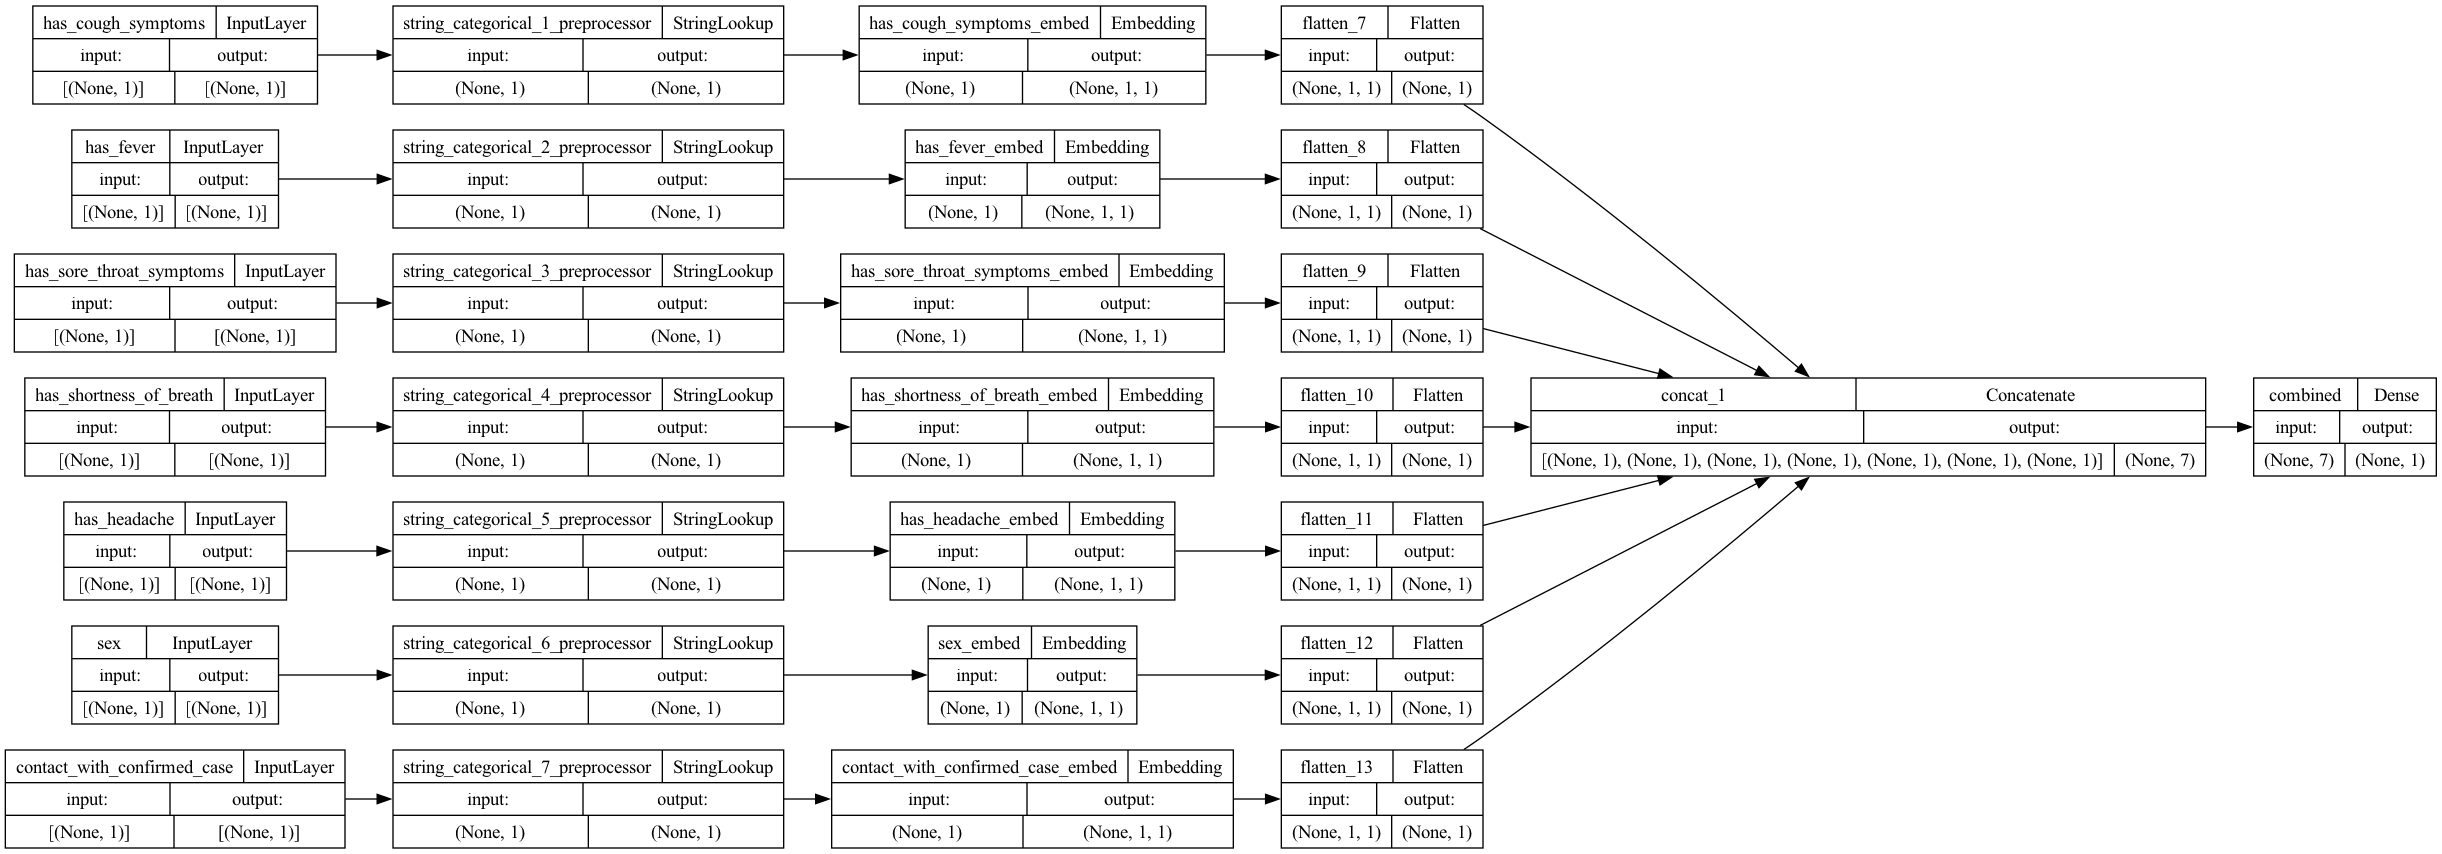

In [39]:
dict_inputs = feature_space_1.get_inputs() # need to use unprocessed features here, to gain access to each output

# some lists for keeping track of parts of the model
all_branch_outputs = [] # this is where we will keep track of output of each branch

# for each categorical variable, which is all we have in our dataset
for col in df_train.columns:
    if col != "tested_positive_for_covid":
        # get the output tensor from ebedding layer
        x = setup_embedding_from_categorical(feature_space_1, col)
        
        # save these outputs in list to concatenate later
        all_branch_outputs.append(x)
    
# now concatenate the outputs and add a fully connected layer
final_branch = Concatenate(name='concat_1')(all_branch_outputs)
final_branch = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch)

# here, since we are accessing the string lookup data directly, 
#. we cannot use the already processed data
training_model_1 = keras.Model(inputs=dict_inputs, outputs=final_branch)

training_model_1.compile(
    optimizer="adam", 
    loss="binary_crossentropy", 
    metrics=[
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        f2_score,
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

training_model_1.summary()

plot_model(
    training_model_1, 
    to_file='model_1.png', 
    show_shapes=True, show_layer_names=True,
    rankdir='LR', 
    expand_nested=False, 
    dpi=96,
)

In [41]:
history1 = training_model_1.fit(
    ds_train, epochs=10, validation_data=ds_test, verbose=2
)

Epoch 1/10


6477/6477 - 157s - loss: 0.1592 - precision_3: 0.7479 - recall_3: 0.5038 - f2_score: 0.4549 - val_loss: 0.1587 - val_precision_3: 0.7488 - val_recall_3: 0.5229 - val_f2_score: 0.4716 - 157s/epoch - 24ms/step
Epoch 2/10
6477/6477 - 156s - loss: 0.1592 - precision_3: 0.7483 - recall_3: 0.5120 - f2_score: 0.4563 - val_loss: 0.1586 - val_precision_3: 0.7488 - val_recall_3: 0.5229 - val_f2_score: 0.4716 - 156s/epoch - 24ms/step
Epoch 3/10
6477/6477 - 157s - loss: 0.1592 - precision_3: 0.7483 - recall_3: 0.5110 - f2_score: 0.4585 - val_loss: 0.1587 - val_precision_3: 0.7488 - val_recall_3: 0.5229 - val_f2_score: 0.4716 - 157s/epoch - 24ms/step
Epoch 4/10
6477/6477 - 156s - loss: 0.1592 - precision_3: 0.7484 - recall_3: 0.5121 - f2_score: 0.4609 - val_loss: 0.1586 - val_precision_3: 0.7488 - val_recall_3: 0.5229 - val_f2_score: 0.4716 - 156s/epoch - 24ms/step
Epoch 5/10
6477/6477 - 157s - loss: 0.1592 - precision_3: 0.7484 - recall_3: 0.5122 - f2_score: 0.4543 - val_loss: 0.1588 - val_precisi

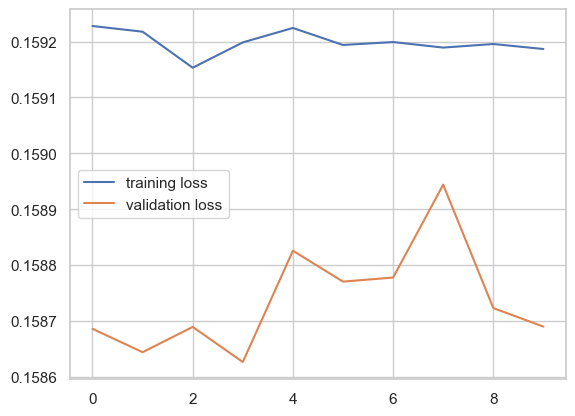

In [48]:
plt.plot(history1.history['loss'],label='training loss')
plt.plot(history1.history['val_loss'],label='validation loss')
plt.legend()
plt.show()

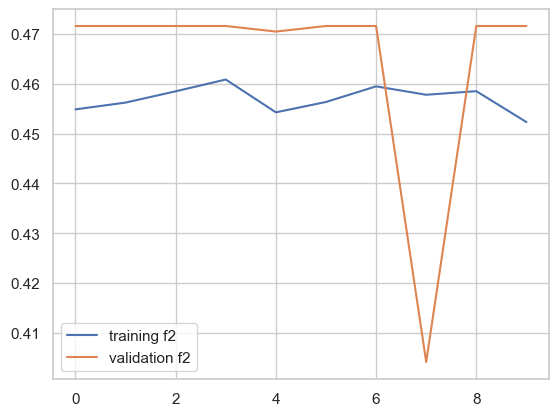

In [49]:
plt.plot(history1.history['f2_score'],label='training f2')
plt.plot(history1.history['val_f2_score'],label='validation f2')
plt.legend()
plt.show()

### **2.2: Training Our Second Wide & Deep Neural Network**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 has_cough_symptoms (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                                  
 has_fever (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 has_sore_throat_symptoms (  [(None, 1)]                  0         []                            
 InputLayer)                                                                                      
                                                                                            

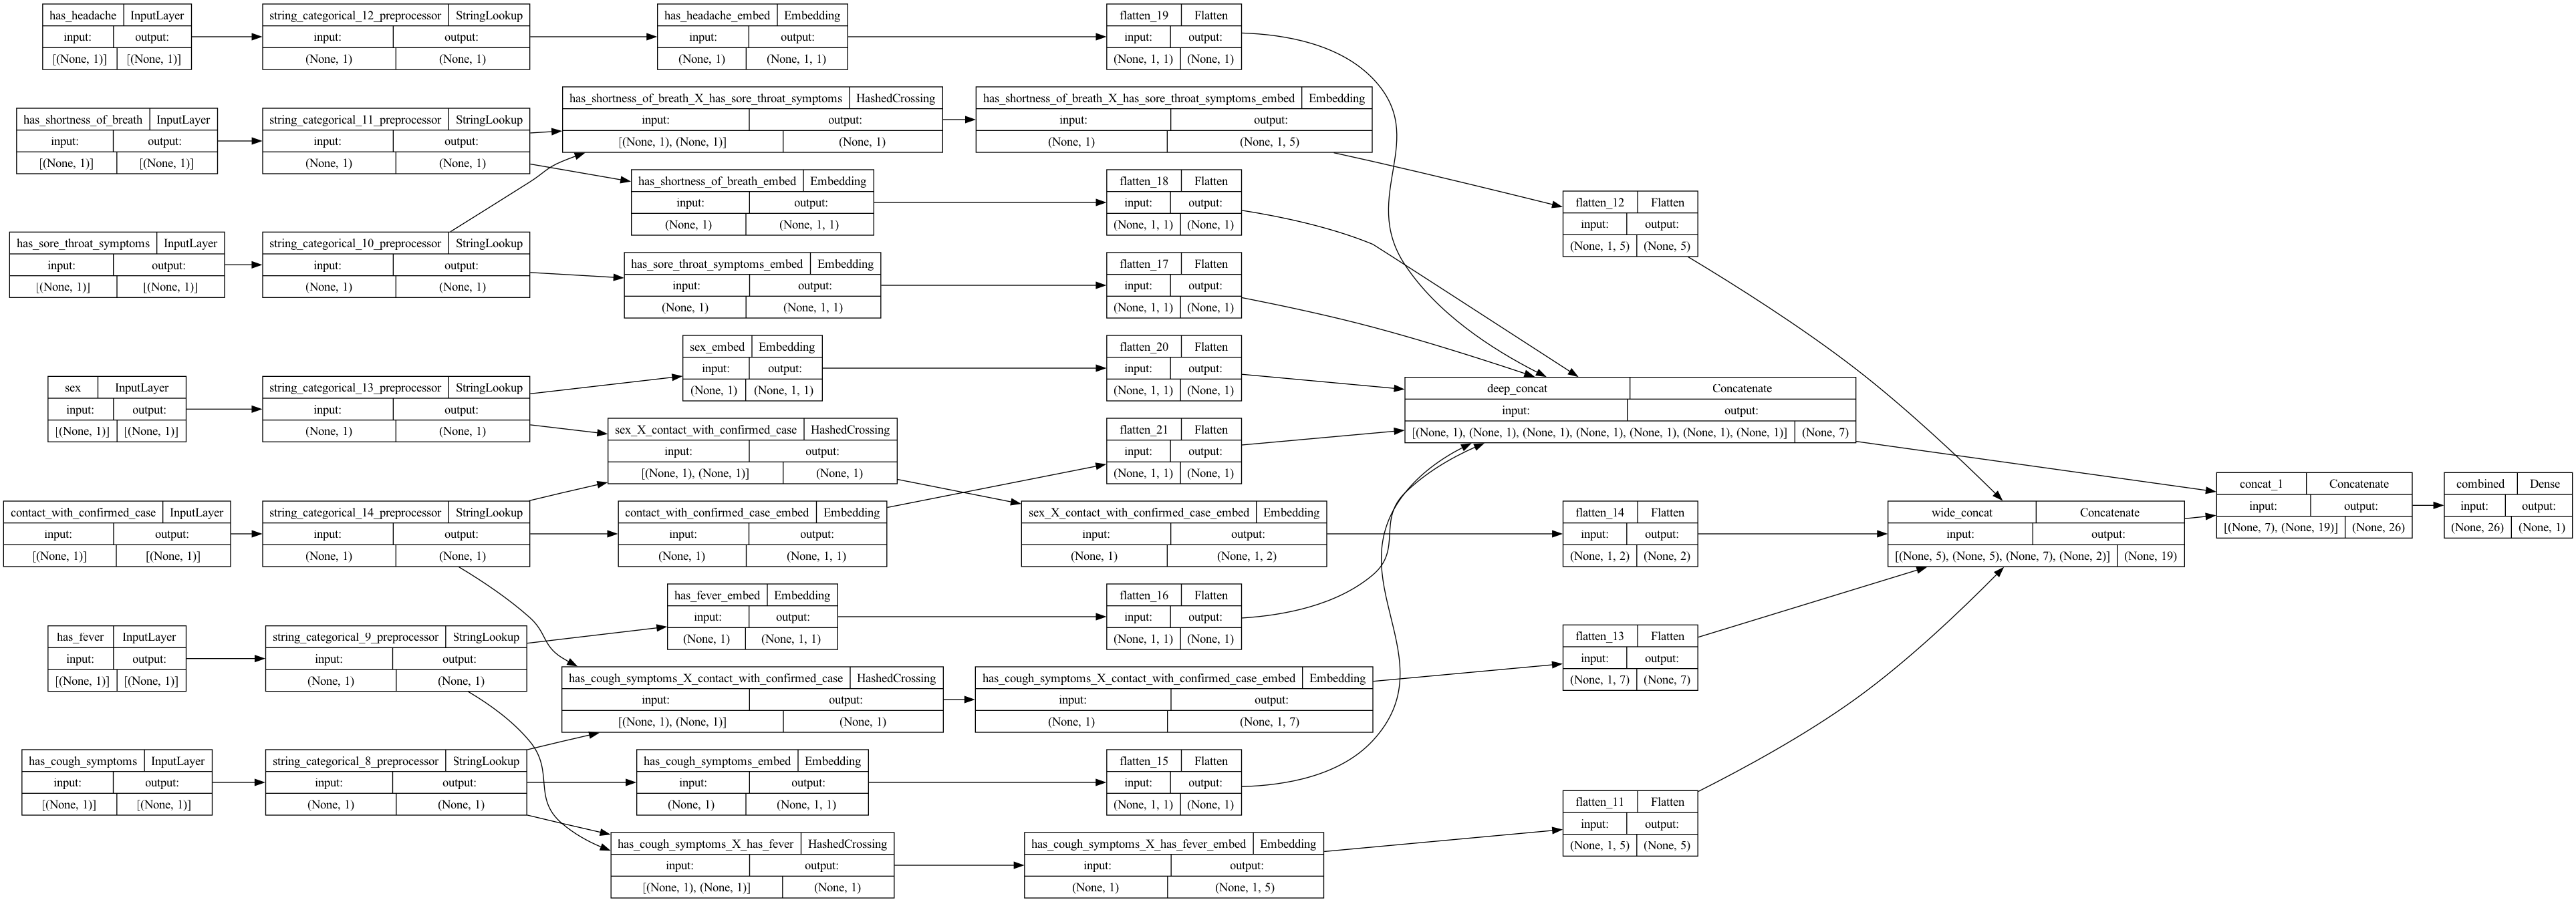

In [40]:
dict_inputs2 = feature_space_2.get_inputs() # need to use unprocessed features here, to gain access to each output


# we need to create separate lists for each branch
crossed_outputs_2 = []

# for each crossed variable, make an embedding
for col in feature_space_2.crossers.keys():
    
    x = setup_embedding_from_crossing(feature_space_2, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs_2.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch_2 = Concatenate(name='wide_concat')(crossed_outputs_2)


# some lists for keeping track of parts of the model
all_deep_branch_outputs_2 = [] # this is where we will keep track of output of each branch

# for each categorical variable, which is all we have in our dataset
for col in df_train.columns:
    if col != "tested_positive_for_covid":
        # get the output tensor from ebedding layer
        x = setup_embedding_from_categorical(feature_space_2, col)
        
        # save these outputs in list to concatenate later
        all_deep_branch_outputs_2.append(x)

# now concatenate the outputs and add a fully connected layer
deep_branch_2 = Concatenate(name='deep_concat')(all_deep_branch_outputs_2)

# now concatenate the outputs and add a fully connected layer
final_branch_2 = Concatenate(name='concat_1')([deep_branch_2, wide_branch_2])
final_branch_2 = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch_2)

# here, since we are accessing the string lookup data directly, 
#. we cannot use the already processed data
training_model_2 = keras.Model(inputs=dict_inputs2, outputs=final_branch_2)

training_model_2.compile(
    optimizer="adam", 
    loss="binary_crossentropy", 
    metrics=[
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        f2_score,
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

training_model_2.summary()

plot_model(
    training_model_2, 
    to_file='model_2.png', 
    show_shapes=True, show_layer_names=True,
    rankdir='LR', 
    expand_nested=False, 
    dpi=96,
)

In [41]:
history2 = training_model_2.fit(
    ds_train, epochs=10, validation_data=ds_test, verbose=2
)

Epoch 1/10


2023-11-12 16:28:28.144702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-12 16:28:28.259471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_22.
2023-11-12 16:32:31.810480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6477/6477 - 264s - loss: 0.1672 - precision_3: 0.7654 - recall_3: 0.3985 - f2_score: 0.3633 - auc: 0.8196 - accuracy: 0.9528 - val_loss: 0.1550 - val_precision_3: 0.7849 - val_recall_3: 0.4857 - val_f2_score: 0.4435 - val_auc: 0.8270 - val_accuracy: 0.9577 - 264s/epoch - 41ms/step
Epoch 2/10
6477/6477 - 262s - loss: 0.1551 - precision_3: 0.8047 - recall_3: 0.4569 - f2_score: 0.4148 - auc: 0.8275 - accuracy: 0.9573 - val_loss: 0.1550 - val_precision_3: 0.7871 - val_recall_3: 0.4942 - val_f2_score: 0.4501 - val_auc: 0.8259 - val_accuracy: 0.9583 - 262s/epoch - 40ms/step
Epoch 3/10
6477/6477 - 250s - loss: 0.1550 - precision_3: 0.8113 - recall_3: 0.4521 - f2_score: 0.4107 - auc: 0.8273 - accuracy: 0.9574 - val_loss: 0.1549 - val_precision_3: 0.8271 - val_recall_3: 0.4555 - val_f2_score: 0.4223 - val_auc: 0.8234 - val_accuracy: 0.9583 - 250s/epoch - 39ms/step
Epoch 4/10
6477/6477 - 247s - loss: 0.1549 - precision_3: 0.8092 - recall_3: 0.4513 - f2_score: 0.4098 - auc: 0.8285 - accuracy: 0.9

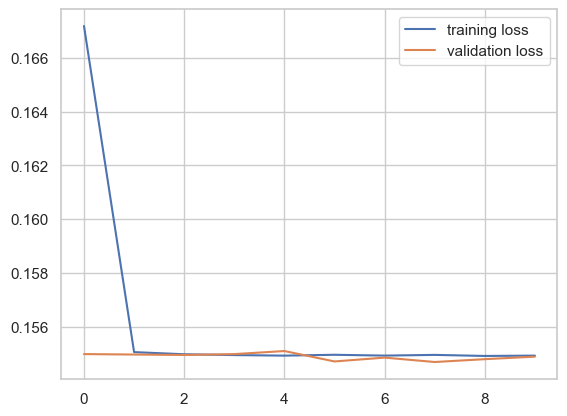

In [42]:
plt.plot(history2.history['loss'],label='training loss')
plt.plot(history2.history['val_loss'],label='validation loss')
plt.legend()
plt.show()

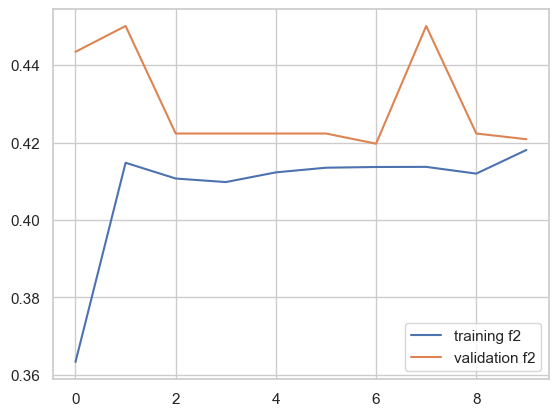

In [43]:
plt.plot(history2.history['f2_score'],label='training f2')
plt.plot(history2.history['val_f2_score'],label='validation f2')
plt.legend()
plt.show()

### **2.3: Training Our Last Wide & Deep Neural Network**

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 has_cough_symptoms (InputL  [(None, 1)]                  0         []                            
 ayer)                                                                                            
                                                                                                  
 has_fever (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 has_sore_throat_symptoms (  [(None, 1)]                  0         []                            
 InputLayer)                                                                                      
                                                                                            

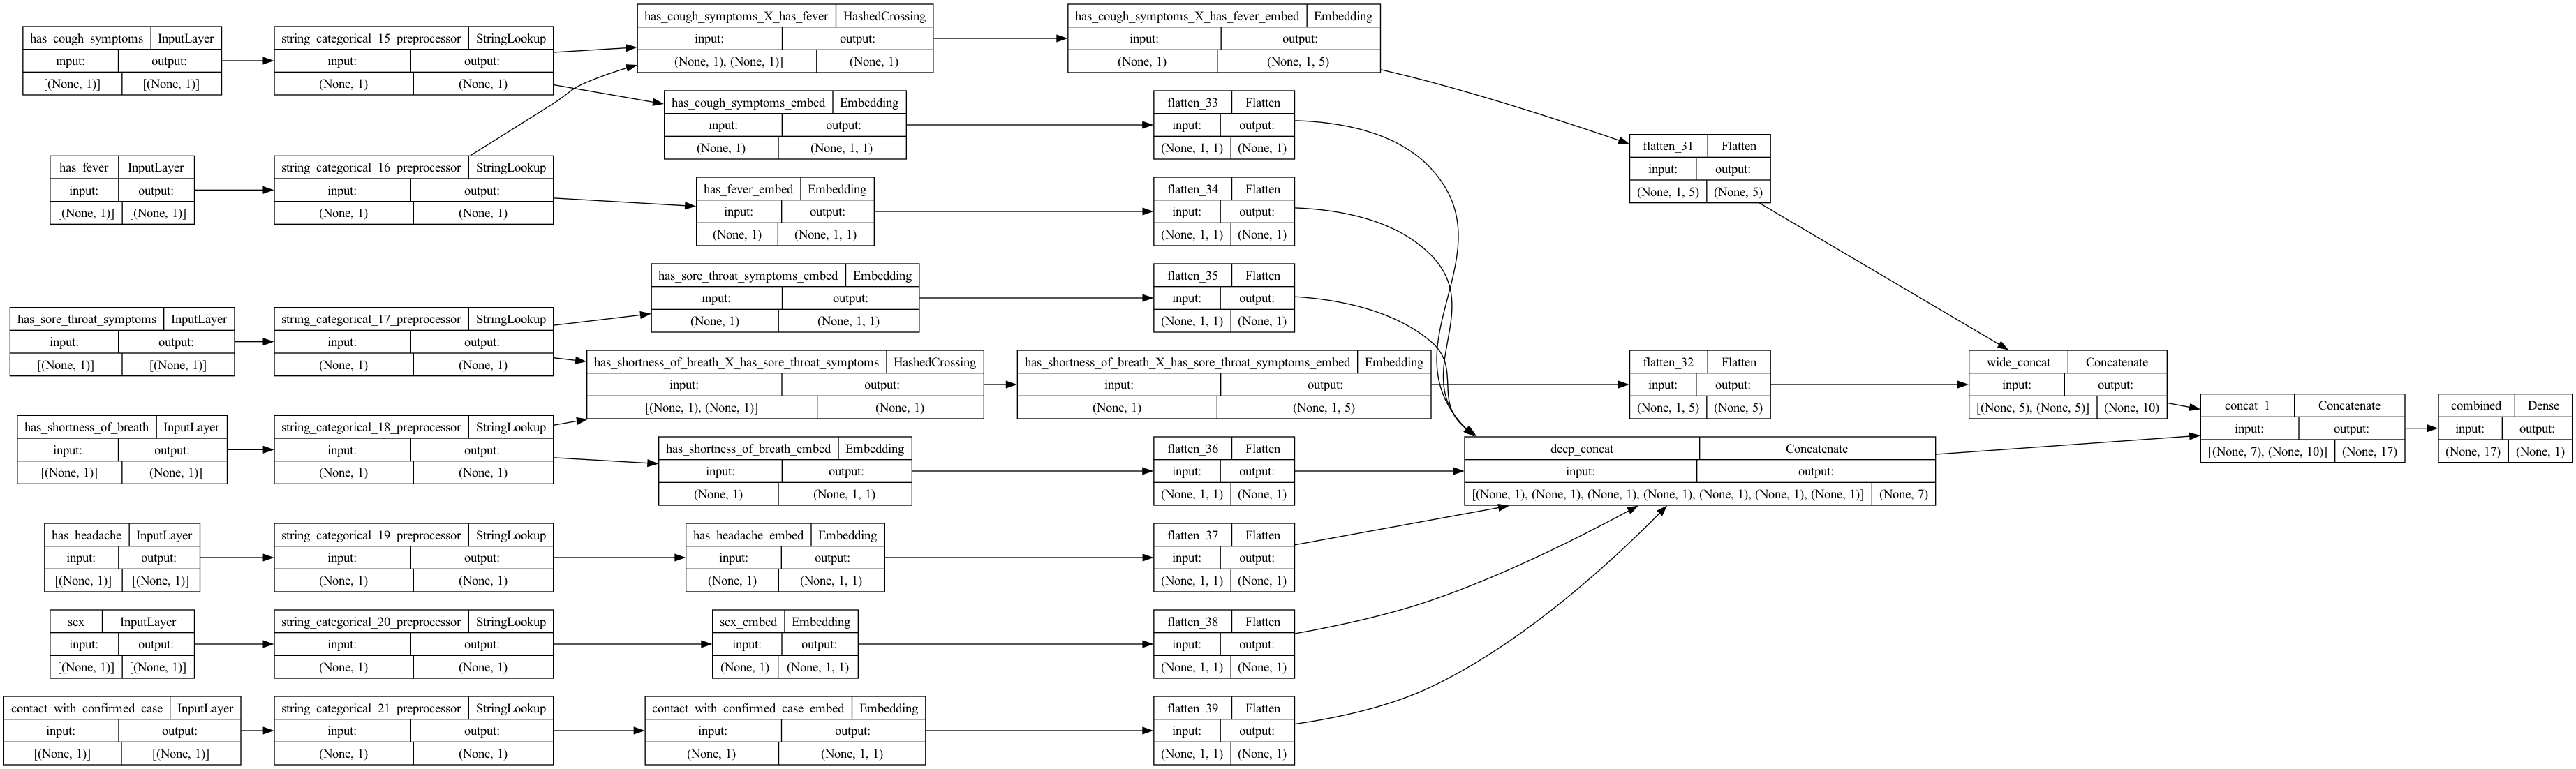

In [45]:
dict_inputs3 = feature_space_3.get_inputs() # need to use unprocessed features here, to gain access to each output


# we need to create separate lists for each branch
crossed_outputs_3 = []

# for each crossed variable, make an embedding
for col in feature_space_3.crossers.keys():
    
    x = setup_embedding_from_crossing(feature_space_3, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs_3.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch_3 = Concatenate(name='wide_concat')(crossed_outputs_3)


# some lists for keeping track of parts of the model
all_deep_branch_outputs_3 = [] # this is where we will keep track of output of each branch

# for each categorical variable, which is all we have in our dataset
for col in df_train.columns:
    if col != "tested_positive_for_covid":
        # get the output tensor from ebedding layer
        x = setup_embedding_from_categorical(feature_space_3, col)
        
        # save these outputs in list to concatenate later
        all_deep_branch_outputs_3.append(x)

# now concatenate the outputs and add a fully connected layer
deep_branch_3 = Concatenate(name='deep_concat')(all_deep_branch_outputs_3)

# now concatenate the outputs and add a fully connected layer
final_branch_3 = Concatenate(name='concat_1')([deep_branch_3, wide_branch_3])
final_branch_3 = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch_3)

# here, since we are accessing the string lookup data directly, 
#. we cannot use the already processed data
training_model_3 = keras.Model(inputs=dict_inputs3, outputs=final_branch_3)

training_model_3.compile(
    optimizer="adam", 
    loss="binary_crossentropy", 
    metrics=[
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        f2_score,
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

training_model_3.summary()

plot_model(
    training_model_3, 
    to_file='model_3.png', 
    show_shapes=True, show_layer_names=True,
    rankdir='LR', 
    expand_nested=False, 
    dpi=96,
)

In [47]:
history3 = training_model_3.fit(
    ds_train, epochs=10, validation_data=ds_test, verbose=2
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'Adam/AssignSubVariableOp_9' defined at (most recent call last):
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/s0/2zhm09_j1y99mpf7ky4y82km0000gn/T/ipykernel_76219/3508002381.py", line 1, in <module>
      history3 = training_model_3.fit(
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1230, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1260, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1352, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1349, in apply_grad_to_update_var
      return self._update_step(grad, var)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 241, in _update_step
      self.update_step(gradient, variable)
    File "/Users/reece/opt/anaconda3/envs/new_tensor/lib/python3.9/site-packages/keras/src/optimizers/adam.py", line 204, in update_step
      variable.assign_sub((m * alpha) / (tf.sqrt(v) + self.epsilon))
Node: 'Adam/AssignSubVariableOp_9'
lr is not a scalar : [25,5]
	 [[{{node Adam/AssignSubVariableOp_9}}]] [Op:__inference_train_function_936940]

In [ ]:
plt.plot(history3.history['loss'],label='training loss')
plt.plot(history3.history['val_loss'],label='validation loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history3.history['loss'],label='training loss')
plt.plot(history3.history['val_loss'],label='validation loss')
plt.legend()
plt.show()

### **2.4: Comparing Wide and Deep Network to Scikit-Learn MLP**

Remember this is how our dataframe looks right now before being passed in.

In [33]:
df_train.sample(20)

,has_cough_symptoms,has_fever,has_sore_throat_symptoms,has_shortness_of_breath,has_headache,sex,contact_with_confirmed_case,tested_positive_for_covid
191650,no,no,no,no,no,female,yes,0
232267,no,no,no,no,no,female,yes,0
108963,yes,no,no,no,no,female,abroad,0
29002,no,no,no,no,no,male,yes,0
142661,yes,no,no,no,no,male,abroad,0
215049,no,no,no,no,no,male,yes,0
144311,yes,no,no,no,no,male,abroad,0
179875,no,no,no,no,no,male,yes,0
183435,no,no,no,no,no,male,yes,0
117511,yes,yes,no,no,no,female,confirmed_contact,1


I need to put it in a way that can be recognized and interpreted outside of Tensorflow by XGBoost.

In [34]:
df_train_xgboost = pd.DataFrame()
df_test_xgboost = pd.DataFrame()

# Get the symptom colnames
symptom_colnames = df_train.columns[np.arange(5)]

def one_hot_encode_symptom(cell: str) -> int:
    return 1 if cell == "yes" else 0

# One hot encode symptoms
for symptom in symptom_colnames:
    df_train_xgboost[symptom] = df_train[symptom].apply(one_hot_encode_symptom)
    df_test_xgboost[symptom] = df_test[symptom].apply(one_hot_encode_symptom)

# One-hot-encode gender
def one_hot_male(cell: str) -> int:
    return 1 if cell == "male" else 0
def one_hot_female(cell: str) -> int:
    return 1 if cell == "female" else 0

df_train_xgboost["is_male"] = df_train["sex"].apply(one_hot_male)
df_train_xgboost["is_female"] = df_train["sex"].apply(one_hot_female)
df_test_xgboost["is_male"] = df_test["sex"].apply(one_hot_male)
df_test_xgboost["is_female"] = df_test["sex"].apply(one_hot_female)

# One-hot-encode confirmed case values
def one_hot_confirmed_contact(cell: str) -> int:
    return 1 if cell == "confirmed_contact" else 0
def one_hot_no_confirmed_contact(cell: str) -> int:
    return 1 if cell == "yes" else 0
def one_hot_confirmed_abroad(cell: str) -> int:
    return 1 if cell == "abroad" else 0

df_train_xgboost["had_confirmed_contact"] = df_train["contact_with_confirmed_case"].apply(one_hot_confirmed_contact)
df_train_xgboost["no_confirmed_contact"] = df_train["contact_with_confirmed_case"].apply(one_hot_no_confirmed_contact)
df_train_xgboost["abroad_confirmed_contact"] = df_train["contact_with_confirmed_case"].apply(one_hot_confirmed_abroad)
df_test_xgboost["had_confirmed_contact"] = df_test["contact_with_confirmed_case"].apply(one_hot_confirmed_contact)
df_test_xgboost["no_confirmed_contact"] = df_test["contact_with_confirmed_case"].apply(one_hot_no_confirmed_contact)
df_test_xgboost["abroad_confirmed_contact"] = df_test["contact_with_confirmed_case"].apply(one_hot_confirmed_abroad)

# COVID
df_train_xgboost["tested_positive_for_covid"] = df_train["tested_positive_for_covid"]
df_test_xgboost["tested_positive_for_covid"] = df_test["tested_positive_for_covid"]

df_train_xgboost.sample(20)

,has_cough_symptoms,has_fever,has_sore_throat_symptoms,has_shortness_of_breath,has_headache,is_male,is_female,had_confirmed_contact,no_confirmed_contact,abroad_confirmed_contact,tested_positive_for_covid
102213,0,0,0,0,0,1,0,0,1,0,0
178837,0,0,0,0,0,0,1,0,1,0,0
35794,0,0,0,0,0,0,1,0,1,0,0
44710,0,0,0,0,0,1,0,0,1,0,0
152643,1,0,0,0,0,0,1,0,1,0,0
247933,0,0,0,0,0,0,1,0,1,0,0
208811,0,0,0,0,0,1,0,0,1,0,0
246307,0,0,0,0,0,0,1,0,1,0,0
172989,0,0,0,0,0,0,1,0,1,0,0
162607,0,0,0,0,0,1,0,0,1,0,0


Now, we will train a standard Multi-Layer Perceptron and evaluate how it performs in comparison to the wide and deep networks trained above. 

CPU times: user 20.4 s, sys: 151 ms, total: 20.5 s
Wall time: 20.6 s
F2 score: 0.534185303514377


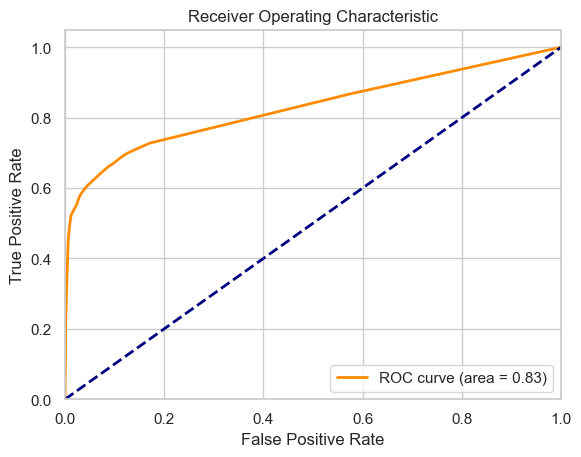

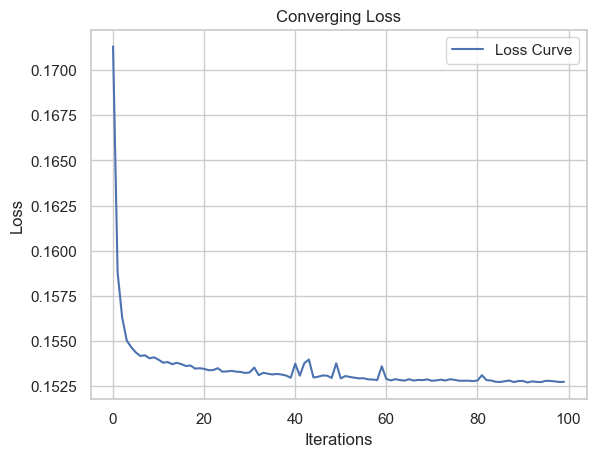

In [41]:
# ROC and Loss plotted with ChatGPT
from sklearn.neural_network import MLPClassifier

# =================
# Import Statements
# =================

# Values Hand Tuned, Sigmoid W/ SGD, Batching, Nesterov's Momentum, L2, Adaptive Learning Rate
# Hand Tuned Parameters
clf = MLPClassifier(hidden_layer_sizes =  (50,), 
                    activation =          'logistic', # Compare To Sigmoid
                    solver =              'sgd', 
                    alpha =               1e-4,       # L2 penalty
                    batch_size =          128,        # Min 128
                    learning_rate =       'adaptive', # Decrease Rate If Loss Increases
                    learning_rate_init =  0.1,        # Only For SGD
                    power_t =             0.5,        # Only SGD With Inverse Scaling
                    max_iter =            100, 
                    shuffle =             True, 
                    random_state =        1, 
                    tol =                 1e-9,       # For Stopping
                    verbose =             False, 
                    warm_start =          False, 
                    momentum =            0.9,        # Only SGD
                    nesterovs_momentum =  True,       # Only SGD
                    early_stopping =      False, 
                    validation_fraction = 0.1,        # Only If Early Stopping
                    beta_1 =              0.9,        # Adam Decay Rate Of Moment
                    beta_2 =              0.999,      # Adam Decay Rate Of Moment
                    epsilon =             1e-08)      # Adam Numerical Stabilizer

# Run Prediction
%time clf.fit(X_train, y_train)
yhat = clf.predict(X_test)

# After fitting the model
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Calculate F2 score
f2 = fbeta_score(y_test, yhat, beta=2)
print(f"F2 score: {f2}")

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Converging Loss
plt.figure()
plt.plot(clf.loss_curve_, label='Loss Curve')
plt.title('Converging Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **2.5: XGBoost (Exceptional Credit)**

XGBoost is an extremely popular machine learning algorithm because of its performance in classification tasks. XGBoost employs an ensemble of decision trees, working in concert through a boosting framework. This framework is iterative, where each new tree incrementally corrects the errors made by the preceding sequence of trees, thus improving the model's accuracy with each step. One of the algorithm's most salient features is its use of gradient boosting, a process that leverages the gradient of the loss function to minimize errors systematically.

In the specific context of predicting COVID-19 test outcomes from questionnaire data, XGBoost offers several advantages. Its ability to discern the intricate and nonlinear relationships between a variety of symptoms and test results is extremely key here. Also given the one-hot-encoded nature of our program, the ability of boosted trees to discern combinations of questions answered may be able to perform better than our wide and deep neural networks that have the leverage from us to establish relationships in advance and pass the data through several layers training several parameters. Given that symptom presentation and disease progression can vary widely among individuals, a model's capacity to capture this complexity is crucial. XGBoost's integrated regularization helps prevent overfitting, ensuring that the model remains general and applicable to new data, which is essential especially given the expense of COVID tests especially back in 2021.

Furthermore, XGBoost provides a mechanism to handle imbalanced datasets which is a huge issue we have here. The algorithm's adeptness at managing sparse data—often a characteristic of medical datasets—also stands out, as does its facility for dealing with missing information without the need for elaborate imputation strategies.

From a practical standpoint, these features of XGBoost are invaluable. They allow for the creation of a model that not only identifies patterns within the data but also provides insights into which symptoms are most predictive of the disease. Such insights could guide healthcare professionals in prioritizing testing and treatment strategies.

In summary, XGBoost's versatility and robustness to typical data challenges in medical datasets make it a compelling choice for predicting COVID-19 test outcomes. Its practical application in this realm could potentially streamline the testing process, offer a more nuanced understanding of symptom interplay, and ultimately, inform more effective public health responses.

Below is the code for training our XGBoost model.

[0]	validation_0-logloss:0.25398	validation_1-logloss:0.25378
[1]	validation_0-logloss:0.23869	validation_1-logloss:0.23821


[2]	validation_0-logloss:0.22665	validation_1-logloss:0.22610
[3]	validation_0-logloss:0.21675	validation_1-logloss:0.21615
[4]	validation_0-logloss:0.20840	validation_1-logloss:0.20777
[5]	validation_0-logloss:0.20132	validation_1-logloss:0.20068
[6]	validation_0-logloss:0.19525	validation_1-logloss:0.19457
[7]	validation_0-logloss:0.19002	validation_1-logloss:0.18925
[8]	validation_0-logloss:0.18550	validation_1-logloss:0.18465
[9]	validation_0-logloss:0.18157	validation_1-logloss:0.18069
[10]	validation_0-logloss:0.17820	validation_1-logloss:0.17735
[11]	validation_0-logloss:0.17528	validation_1-logloss:0.17441
[12]	validation_0-logloss:0.17272	validation_1-logloss:0.17183
[13]	validation_0-logloss:0.17049	validation_1-logloss:0.16959
[14]	validation_0-logloss:0.16858	validation_1-logloss:0.16766
[15]	validation_0-logloss:0.16690	validation_1-logloss:0.16596
[16]	validation_0-logloss:0.16542	validation_1-logloss:0.16448
[17]	validation_0-logloss:0.16415	validation_1-logloss:0.16317


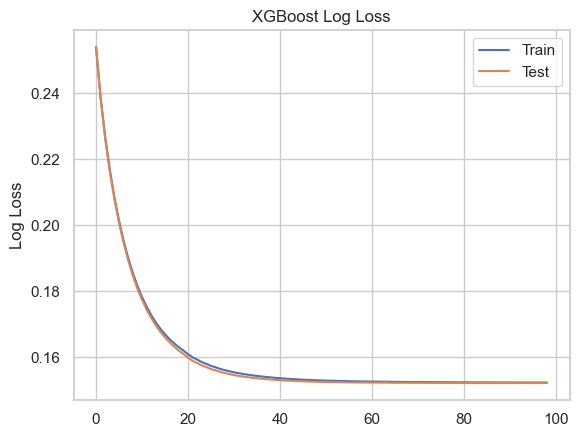

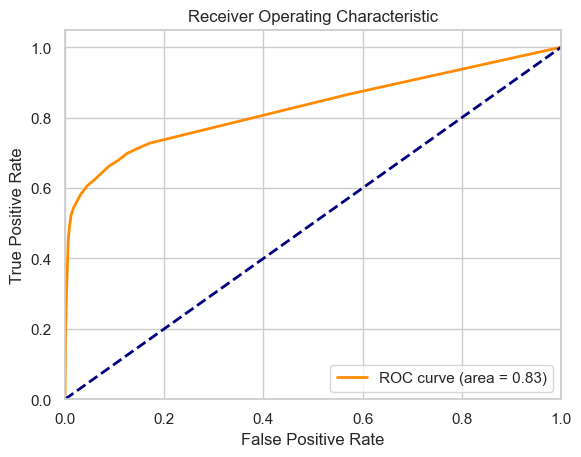

In [39]:
import xgboost as xgb

# Prepare the data
X_train = df_train_xgboost.drop("tested_positive_for_covid", axis=1)
X_test = df_test_xgboost.drop("tested_positive_for_covid", axis=1)
y_train = df_train_xgboost["tested_positive_for_covid"]
y_test = df_test_xgboost["tested_positive_for_covid"]

# Set up model's parameters
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Initialize the XGBoost classifier with the parameters
bst = xgb.XGBClassifier(**params, use_label_encoder=False, n_estimators=100, verbosity=1)

# Train the model
eval_set = [
    (X_train, y_train), 
    (X_test, y_test),
]
bst.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

# Make predictions
y_pred_proba = bst.predict_proba(X_test)[:,1]  # get the probability of the positive class
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}\nRecall: {recall}\nF2: {f2}")

# Plot Loss Curve
results = bst.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### **2.4: Which model is the best?**